# Library

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [3]:
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN

In [4]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from xgboost import XGBRegressor

In [5]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [6]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [7]:
from sklearn.metrics import classification_report, f1_score
from sklearn.inspection import permutation_importance

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic') 

In [9]:
from tqdm.notebook import tqdm

In [10]:
import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [11]:
train = pd.read_csv('open/train.csv')
test = pd.read_csv('open/test.csv')

In [12]:
print(train.columns)
print(test.columns)

Index(['ID', '대출금액', '대출기간', '근로기간', '주택소유상태', '연간소득', '부채_대비_소득_비율', '총계좌수',
       '대출목적', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '대출등급'],
      dtype='object')
Index(['ID', '대출금액', '대출기간', '근로기간', '주택소유상태', '연간소득', '부채_대비_소득_비율', '총계좌수',
       '대출목적', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수'],
      dtype='object')


# Preprocessing

## New Value Names

In [13]:
cond_loan_term_36 = (train['대출기간']==' 36 months')

train.loc[cond_loan_term_36, '대출기간'] = '36M'
train.loc[~cond_loan_term_36, '대출기간'] = '60M'

cond_loan_term_36 = (test['대출기간']==' 36 months')

test.loc[cond_loan_term_36, '대출기간'] = '36M'
test.loc[~cond_loan_term_36, '대출기간'] = '60M'

train['대출기간'] = train['대출기간'].str.split('M').apply(lambda x: int(x[0]))
test['대출기간'] = test['대출기간'].str.split('M').apply(lambda x: int(x[0]))

In [14]:
# Longer 10Y
cond_employ_dur_10Y_1 = (train['근로기간']=='10+ years')
cond_employ_dur_10Y_2 = (train['근로기간']=='10+years')

train.loc[cond_employ_dur_10Y_1, '근로기간'] = '10 years'
train.loc[cond_employ_dur_10Y_2, '근로기간'] = '10 years'

cond_employ_dur_10Y_1 = (test['근로기간']=='10+ years')
cond_employ_dur_10Y_2 = (test['근로기간']=='10+years')

test.loc[cond_employ_dur_10Y_1, '근로기간'] = '10 years'
test.loc[cond_employ_dur_10Y_2, '근로기간'] = '10 years'

# 3Y
cond_employ_dur_3Y = (train['근로기간']=='3')
train.loc[cond_employ_dur_3Y, '근로기간'] = '3 years'
cond_employ_dur_3Y = (test['근로기간']=='3')
test.loc[cond_employ_dur_3Y, '근로기간'] = '3 years'

# 1Y
cond_employ_dur_1Y_1 = (train['근로기간']=='1 year')
train.loc[cond_employ_dur_1Y_1, '근로기간'] = '1 years'
cond_employ_dur_1Y_1 = (test['근로기간']=='1 year')
test.loc[cond_employ_dur_1Y_1, '근로기간'] = '1 years'

# Shorter 1Y
cond_employ_dur_down_1Y_1 = (train['근로기간']=='< 1 year')
cond_employ_dur_down_1Y_2 = (train['근로기간']=='<1 year')

train.loc[cond_employ_dur_down_1Y_1, '근로기간'] = '0 years'
train.loc[cond_employ_dur_down_1Y_2, '근로기간'] = '0 years'

cond_employ_dur_down_1Y_1 = (test['근로기간']=='< 1 year')
cond_employ_dur_down_1Y_2 = (test['근로기간']=='<1 year')

test.loc[cond_employ_dur_down_1Y_1, '근로기간'] = '0 years'
test.loc[cond_employ_dur_down_1Y_2, '근로기간'] = '0 years'

# Unknown
cond_unknown = (train['근로기간'] == 'Unknown')
train.loc[cond_unknown, '근로기간'] = '999 years'

cond_unknown = (test['근로기간'] == 'Unknown')
test.loc[cond_unknown, '근로기간'] = '999 years'

train['근로기간'] = train['근로기간'].str.split(' ').apply(lambda x: int(x[0]))
test['근로기간'] = test['근로기간'].str.split(' ').apply(lambda x: int(x[0]))

In [15]:
cond_long = (train['근로기간']<=10) & (train['근로기간']>6) 
train.loc[cond_long, '근속기간'] = '장기'

cond_middle = (train['근로기간']<=6) & (train['근로기간']>3)
train.loc[cond_middle, '근속기간'] = '중기'

cond_short = (train['근로기간']<=3) & (train['근로기간']>=1)
train.loc[cond_short, '근속기간'] = '단기'

cond_intern = (train['근로기간']==0)
train.loc[cond_intern, '근속기간'] = '인턴'

cond_nan = (train['근로기간']==999)
train.loc[cond_nan, '근속기간'] = '결측치'

cond_long = (test['근로기간']<=10) & (test['근로기간']>6) 
test.loc[cond_long, '근속기간'] = '장기'

cond_middle = (test['근로기간']<=6) & (test['근로기간']>3)
test.loc[cond_middle, '근속기간'] = '중기'

cond_short = (test['근로기간']<=3) & (test['근로기간']>=1)
test.loc[cond_short, '근속기간'] = '단기'

cond_intern = (test['근로기간']==0)
test.loc[cond_intern, '근속기간'] = '인턴'

cond_nan = (test['근로기간']==999)
test.loc[cond_nan, '근속기간'] = '결측치'

train.drop(columns=['근로기간'], inplace=True)
test.drop(columns=['근로기간'], inplace=True)

## New Columns

In [16]:
train['근사이자율'] = (train['총상환이자'] / train['대출기간']) / train['총상환원금'] * 100
test['근사이자율'] = (test['총상환이자'] / test['대출기간']) / test['총상환원금'] * 100

print(train[['근사이자율']].isnull().sum())

train['대출기간'] = train['대출기간'].astype('object')
test['대출기간'] = test['대출기간'].astype('object')

근사이자율    5407
dtype: int64


In [17]:
train['대출금_대비_총상환이자'] =  train['총상환이자'] / train['대출금액']
test['대출금_대비_총상환이자'] =  test['총상환이자'] / test['대출금액'] 

train['대출금_대비_총상환원금'] =  train['총상환원금'] / train['대출금액']
test['대출금_대비_총상환원금'] =  test['총상환원금'] / test['대출금액'] 

In [18]:
train['소득_대비_대출금'] = train['연간소득'] / train['대출금액'] 
test['소득_대비_대출금'] = test['연간소득'] / test['대출금액'] 

In [19]:
train['소득_대비_부채_비율'] = ((train['총상환원금']+train['총상환이자'])/12)/(train['연간소득']/12)*100
test['소득_대비_부채_비율'] = ((test['총상환원금']+test['총상환이자'])/12)/(test['연간소득']/12)*100

## Num to Cat

In [20]:
cond = (train['연체계좌수']==0) & (train['총연체금액']==0)
train.loc[cond, '연체여부'] = 0
train.loc[~cond, '연체여부'] = 1

cond = (test['연체계좌수']==0) & (test['총연체금액']==0)
test.loc[cond, '연체여부'] = 0
test.loc[~cond, '연체여부'] = 1

train['연체여부'] = train['연체여부'].astype('object')
test['연체여부'] = test['연체여부'].astype('object')

## Merage Value

In [21]:
# cond_home = (train['대출목적']=='이사') | (train['대출목적']=='주택') 
# train.loc[cond_home, '대출목적'] = 'home'

# cond_inter =  (train['대출목적']=='재생 에너지') | (train['대출목적']=='주택 개선')
# train.loc[cond_inter, '대출목적'] = 'inter'

# cond_dept = (train['대출목적']== '부채 통합')
# train.loc[cond_dept, '대출목적'] = 'dept'

# cond_fin = (train['대출목적']=='신용 카드')
# train.loc[cond_fin, '대출목적'] = 'fin'

# cond_buy =  (train['대출목적']== '주요 구매') | (train['대출목적']=='휴가') | (train['대출목적']=='의료') |  (train['대출목적'] == '기타')
# train.loc[cond_buy, '대출목적'] = 'buy'

# cond_car =  (train['대출목적']=='자동차')
# train.loc[cond_car, '대출목적'] = 'car'

# cond_busin = (train['대출목적']=='소규모 사업')
# train.loc[cond_busin, '대출목적'] = 'business'

# cond_all = cond_home | cond_dept | cond_busin | cond_fin | cond_buy | cond_inter
# train.loc[~cond_all, '대출목적'] = 'buy'

# cond_home = (test['대출목적']=='이사') | (test['대출목적']=='주택') 
# test.loc[cond_home, '대출목적'] = 'home'

# cond_inter =  (test['대출목적']=='재생 에너지') | (test['대출목적']=='주택 개선')
# test.loc[cond_inter, '대출목적'] = 'inter'

# cond_dept = (test['대출목적']== '부채 통합')
# test.loc[cond_dept, '대출목적'] = 'dept'

# cond_fin = (test['대출목적']=='신용 카드')
# test.loc[cond_fin, '대출목적'] = 'fin'

# cond_buy =  (test['대출목적']== '주요 구매') | (test['대출목적']=='휴가') | (test['대출목적']=='의료') |  (test['대출목적'] == '기타')
# test.loc[cond_buy, '대출목적'] = 'buy'

# cond_car =  (test['대출목적']=='자동차')
# test.loc[cond_car, '대출목적'] = 'car'

# cond_busin = (test['대출목적']=='소규모 사업')
# test.loc[cond_busin, '대출목적'] = 'business'

# cond_all = cond_home | cond_dept | cond_busin | cond_fin | cond_buy | cond_inter
# test.loc[~cond_all, '대출목적'] = 'buy'

In [22]:
cond_home = (train['대출목적']=='이사') | (train['대출목적']=='주택') 
train.loc[cond_home, '대출목적'] = 'home'

cond_inter =  (train['대출목적']=='재생 에너지') | (train['대출목적']=='주택 개선')
train.loc[cond_inter, '대출목적'] = 'inter'

cond_dept = (train['대출목적']== '부채 통합')
train.loc[cond_dept, '대출목적'] = 'dept'

cond_fin = (train['대출목적']=='신용 카드')
train.loc[cond_fin, '대출목적'] = 'fin'

cond_buy =  (train['대출목적']== '주요 구매') | (train['대출목적']=='휴가') | (train['대출목적']=='의료') | (train['대출목적']=='자동차') |  (train['대출목적'] == '기타')
train.loc[cond_buy, '대출목적'] = 'buy'

cond_busin = (train['대출목적']=='소규모 사업')
train.loc[cond_busin, '대출목적'] = 'business'

cond_all = cond_home | cond_dept | cond_busin | cond_fin | cond_buy | cond_inter
train.loc[~cond_all, '대출목적'] = 'buy'

cond_home = (test['대출목적']=='이사') | (test['대출목적']=='주택') 
test.loc[cond_home, '대출목적'] = 'home'

cond_inter =  (test['대출목적']=='재생 에너지') | (test['대출목적']=='주택 개선')
test.loc[cond_inter, '대출목적'] = 'inter'

cond_dept = (test['대출목적']== '부채 통합')
test.loc[cond_dept, '대출목적'] = 'dept'

cond_fin = (test['대출목적']=='신용 카드')
test.loc[cond_fin, '대출목적'] = 'fin'

cond_buy =  (test['대출목적']== '주요 구매') | (test['대출목적']=='휴가') | (test['대출목적']=='의료') | (test['대출목적']=='자동차') | (test['대출목적'] == '기타')
test.loc[cond_buy, '대출목적'] = 'buy'

cond_busin = (test['대출목적']=='소규모 사업')
test.loc[cond_busin, '대출목적'] = 'business'

cond_all = cond_home | cond_dept | cond_busin | cond_fin | cond_buy | cond_inter
test.loc[~cond_all, '대출목적'] = 'buy'

In [23]:
# cond_home = (train['대출목적']=='이사') | (train['대출목적']=='재생 에너지') | (train['대출목적']=='주택') | (train['대출목적']=='주택 개선')
# train.loc[cond_home, '대출목적'] = 'home'

# cond_dept = (train['대출목적']== '부채 통합')
# train.loc[cond_dept, '대출목적'] = 'dept'

# cond_fin = (train['대출목적']=='신용 카드')
# train.loc[cond_fin, '대출목적'] = 'fin'

# cond_buy =  (train['대출목적']== '주요 구매') | (train['대출목적']=='휴가') | (train['대출목적']=='의료') | (train['대출목적']=='자동차') |  (train['대출목적'] == '기타')
# train.loc[cond_buy, '대출목적'] = 'buy'

# cond_busin = (train['대출목적']=='소규모 사업')
# train.loc[cond_busin, '대출목적'] = 'business'

# cond_all = cond_home | cond_dept | cond_busin | cond_fin | cond_buy
# train.loc[~cond_all, '대출목적'] = 'buy'

# cond_home = (test['대출목적']=='이사') | (test['대출목적']=='재생 에너지') | (test['대출목적']=='주택') | (test['대출목적']=='주택 개선')
# test.loc[cond_home, '대출목적'] = 'home'

# cond_dept = (test['대출목적']== '부채 통합')
# test.loc[cond_dept, '대출목적'] = 'dept'

# cond_fin = (test['대출목적']=='신용 카드')
# test.loc[cond_fin, '대출목적'] = 'fin'

# cond_buy =  (test['대출목적']== '주요 구매') | (test['대출목적']=='휴가') | (test['대출목적']=='의료') | (test['대출목적']=='자동차') | (test['대출목적'] == '기타')
# test.loc[cond_buy, '대출목적'] = 'buy'

# cond_busin = (test['대출목적']=='소규모 사업')
# test.loc[cond_busin, '대출목적'] = 'business'

# cond_all = cond_home | cond_dept | cond_busin | cond_fin | cond_buy
# test.loc[~cond_all, '대출목적'] = 'buy'

## Encoding

In [24]:
CAT_FEATURES = ['대출기간', '근속기간', '주택소유상태', '대출목적']

encoder = LabelEncoder()

for cat in CAT_FEATURES:
    train[cat] = encoder.fit_transform(train[cat])
    test[cat] = encoder.transform(test[cat])

# EDA

## Categorical Features

In [25]:
def credits_level_counts(col):

    unique_list = list(train[col].unique())
    
    for unique in unique_list:
    
        cond_unique = (train[col]==unique)
        print(unique)
        print(train.loc[cond_unique]['대출등급'].value_counts())
        print()

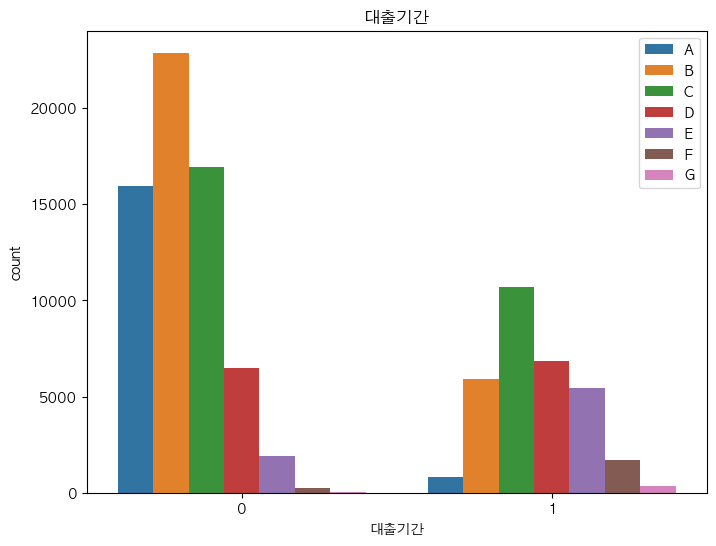


0
대출등급
B    22883
C    16935
A    15952
D     6485
E     1895
F      270
G       59
Name: count, dtype: int64

1
대출등급
C    10688
D     6869
B     5934
E     5459
F     1684
A      820
G      361
Name: count, dtype: int64



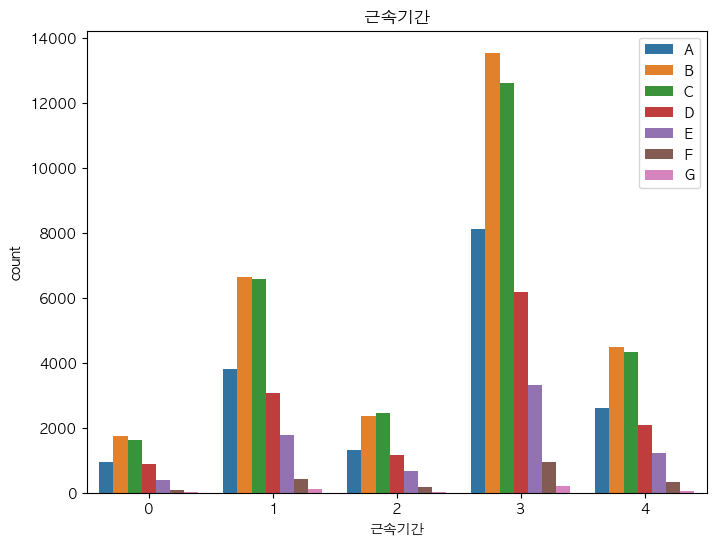


4
대출등급
B    4495
C    4347
A    2605
D    2075
E    1211
F     326
G      68
Name: count, dtype: int64

3
대출등급
B    13557
C    12621
A     8116
D     6172
E     3323
F      941
G      197
Name: count, dtype: int64

0
대출등급
B    1742
C    1628
A     934
D     872
E     378
F      92
G      25
Name: count, dtype: int64

1
대출등급
B    6662
C    6580
A    3800
D    3062
E    1784
F     433
G     104
Name: count, dtype: int64

2
대출등급
C    2447
B    2361
A    1317
D    1173
E     658
F     162
G      26
Name: count, dtype: int64



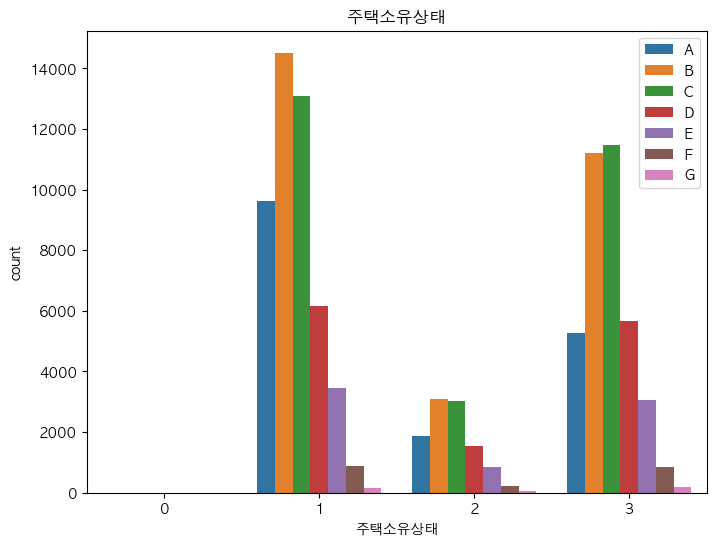


3
대출등급
C    11478
B    11200
D     5653
A     5268
E     3056
F      855
G      195
Name: count, dtype: int64

1
대출등급
B    14518
C    13106
A     9640
D     6163
E     3452
F      883
G      172
Name: count, dtype: int64

2
대출등급
B    3099
C    3038
A    1864
D    1538
E     846
F     216
G      53
Name: count, dtype: int64

0
대출등급
C    1
Name: count, dtype: int64



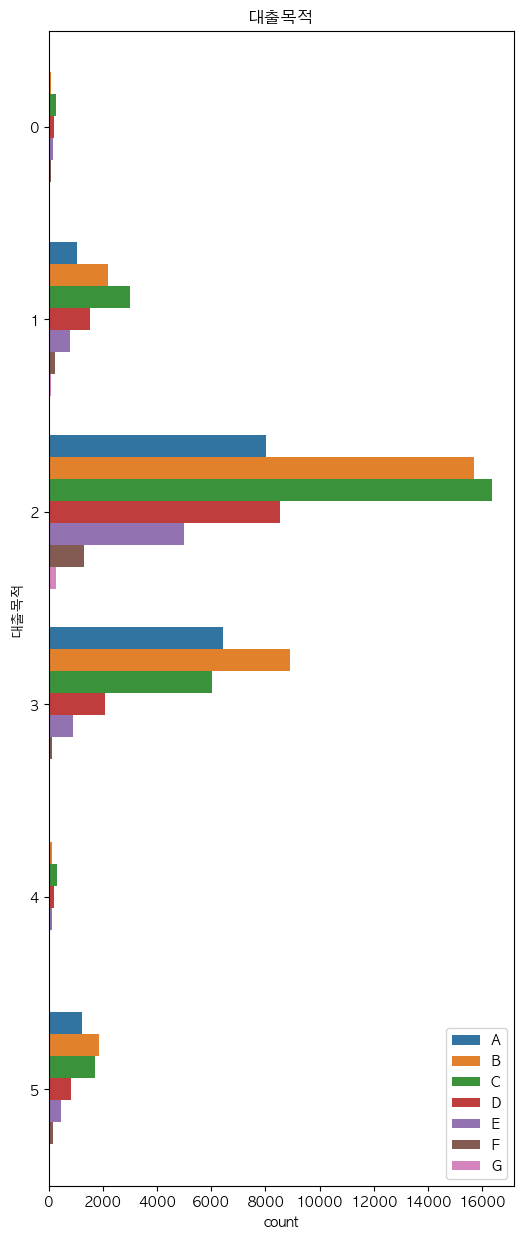


2
대출등급
C    16349
B    15680
D     8529
A     8036
E     4979
F     1311
G      266
Name: count, dtype: int64

5
대출등급
B    1849
C    1709
A    1226
D     826
E     435
F     149
G      26
Name: count, dtype: int64

1
대출등급
C    2992
B    2174
D    1516
A    1046
E     792
F     246
G      64
Name: count, dtype: int64

3
대출등급
B    8917
A    6424
C    6036
D    2092
E     877
F     137
G      17
Name: count, dtype: int64

0
대출등급
C    249
D    192
E    158
B     75
F     64
G     30
A     19
Name: count, dtype: int64

4
대출등급
C    288
D    199
B    122
E    113
F     47
A     21
G     17
Name: count, dtype: int64



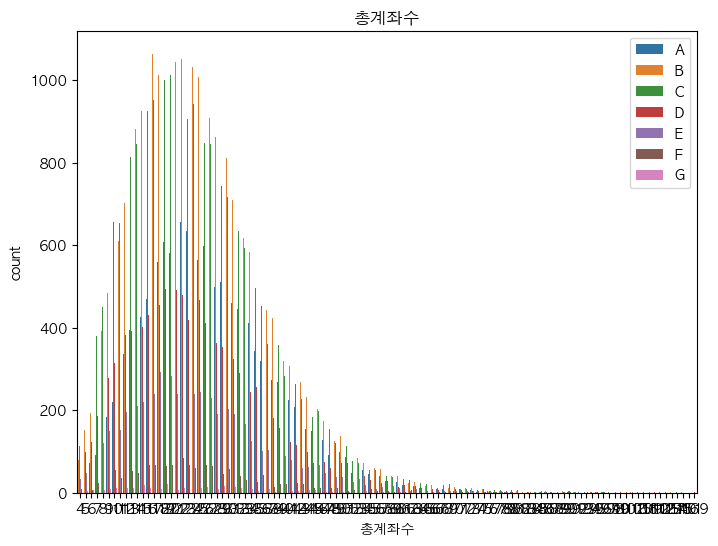


15
대출등급
B    926
C    891
A    426
D    402
E    219
F     61
G     18
Name: count, dtype: int64

21
대출등급
B    1043
C    1017
A     609
D     492
E     240
F      87
G       6
Name: count, dtype: int64

14
대출등급
B    882
C    845
A    441
D    412
E    210
F     47
G     18
Name: count, dtype: int64

19
대출등급
B    1066
C    1001
A     608
D     493
E     228
F      64
G      20
Name: count, dtype: int64

30
대출등급
B    810
C    716
A    522
D    303
E    203
F     58
G     12
Name: count, dtype: int64

22
대출등급
B    1052
C     979
A     655
D     480
E     275
F      84
G      12
Name: count, dtype: int64

45
대출등급
B    205
C    183
A    150
D     71
E     45
F     11
G      6
Name: count, dtype: int64

11
대출등급
C    653
B    610
D    368
A    289
E    153
F     36
G     14
Name: count, dtype: int64

26
대출등급
B    972
C    847
A    598
D    412
E    233
F     66
G     14
Name: count, dtype: int64

10
대출등급
C    655
B    539
D    315
A    221
E    139
F     54
G     11
Name: count, dtype: int64

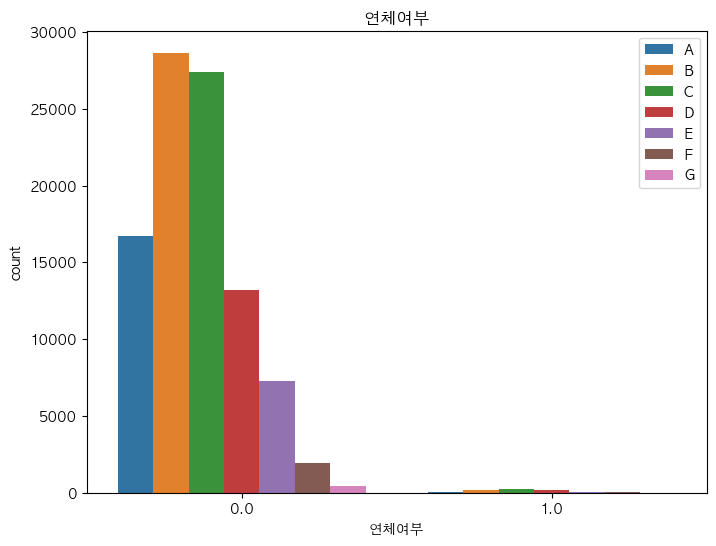


0.0
대출등급
B    28652
C    27366
A    16744
D    13201
E     7275
F     1931
G      415
Name: count, dtype: int64

1.0
대출등급
C    257
B    165
D    153
E     79
A     28
F     23
G      5
Name: count, dtype: int64



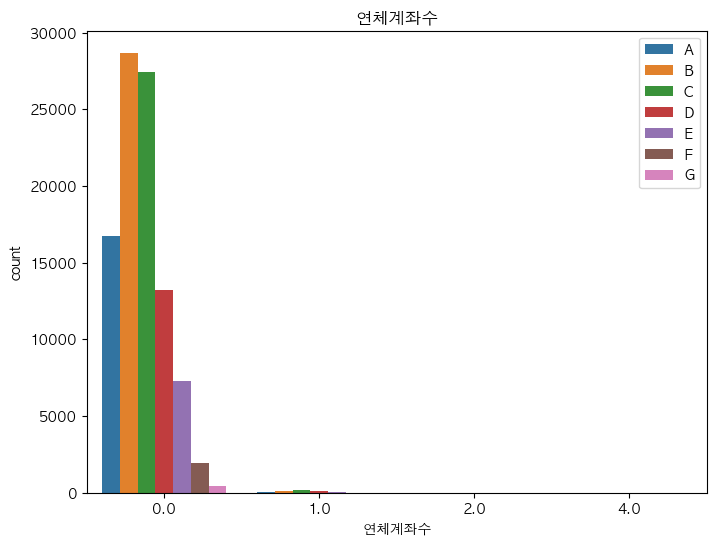


0.0
대출등급
B    28683
C    27418
A    16753
D    13247
E     7301
F     1942
G      418
Name: count, dtype: int64

1.0
대출등급
C    194
B    130
D    101
E     50
A     19
F     11
G      2
Name: count, dtype: int64

2.0
대출등급
C    10
D     6
B     4
E     3
F     1
Name: count, dtype: int64

4.0
대출등급
C    1
Name: count, dtype: int64



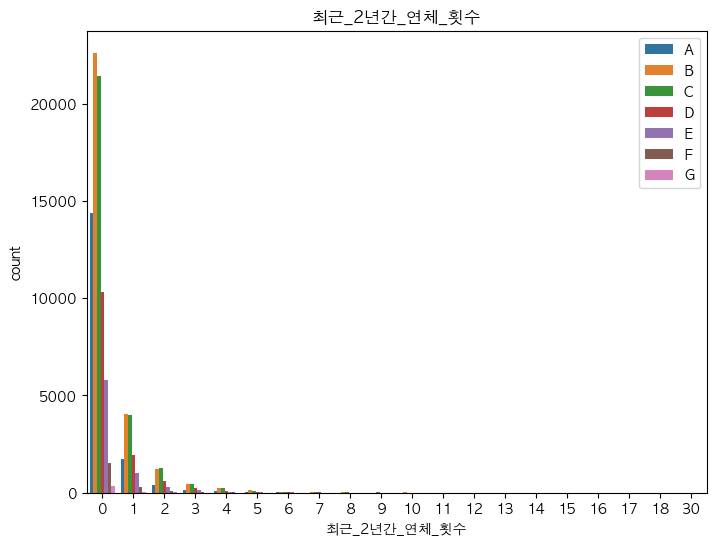


0
대출등급
B    22616
C    21409
A    14377
D    10335
E     5799
F     1527
G      329
Name: count, dtype: int64

1
대출등급
B    4029
C    4016
D    1962
A    1710
E    1028
F     281
G      53
Name: count, dtype: int64

9
대출등급
C    13
D    11
B    10
F     3
A     2
E     1
Name: count, dtype: int64

11
대출등급
C    9
D    6
B    6
Name: count, dtype: int64

6
대출등급
B    62
C    52
D    33
E    14
A    14
G     2
F     1
Name: count, dtype: int64

2
대출등급
C    1252
B    1241
D     589
A     410
E     300
F      80
G      24
Name: count, dtype: int64

3
대출등급
C    472
B    425
D    233
A    138
E    120
F     37
G      5
Name: count, dtype: int64

4
대출등급
C    227
B    226
D    103
A     70
E     49
F     18
G      4
Name: count, dtype: int64

5
대출등급
B    117
C    107
D     52
A     33
E     26
F      3
Name: count, dtype: int64

14
대출등급
C    3
B    3
D    1
A    1
Name: count, dtype: int64

8
대출등급
B    27
C    22
D     8
E     5
A     4
F     1
Name: count, dtype: int64

7
대출등급
B    35
C    24
D 

In [26]:
hue_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

CAT_FEATURES = ['대출기간', '근속기간', '주택소유상태', '대출목적', 
                '총계좌수', '연체여부', '연체계좌수', '최근_2년간_연체_횟수']

for col in CAT_FEATURES:

    if col in ['근로기간', '대출목적']:

       plt.figure(figsize=(6,15))
       sns.countplot(data=train,y=col, hue='대출등급', hue_order=hue_order)
       plt.title(col)
       plt.legend(loc='lower right')
       plt.show()
       print()
       credits_level_counts(col=col)

    else:

        plt.figure(figsize=(8,6))
        sns.countplot(data=train, x=col, hue='대출등급', hue_order=hue_order)
        plt.title(col)
        plt.legend(loc='upper right')
        plt.show()
        print()
        credits_level_counts(col=col)


## Numerical Features

In [27]:
def num_statistic(data, col):
    statistic_df = pd.DataFrame()

    for level in hue_order:
        level_df = data.loc[(data['대출등급']==level)][[col]].describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
        level_df.index = [level]
        
        statistic_df = pd.concat([statistic_df, level_df], axis=0)

    display(statistic_df)
    print()

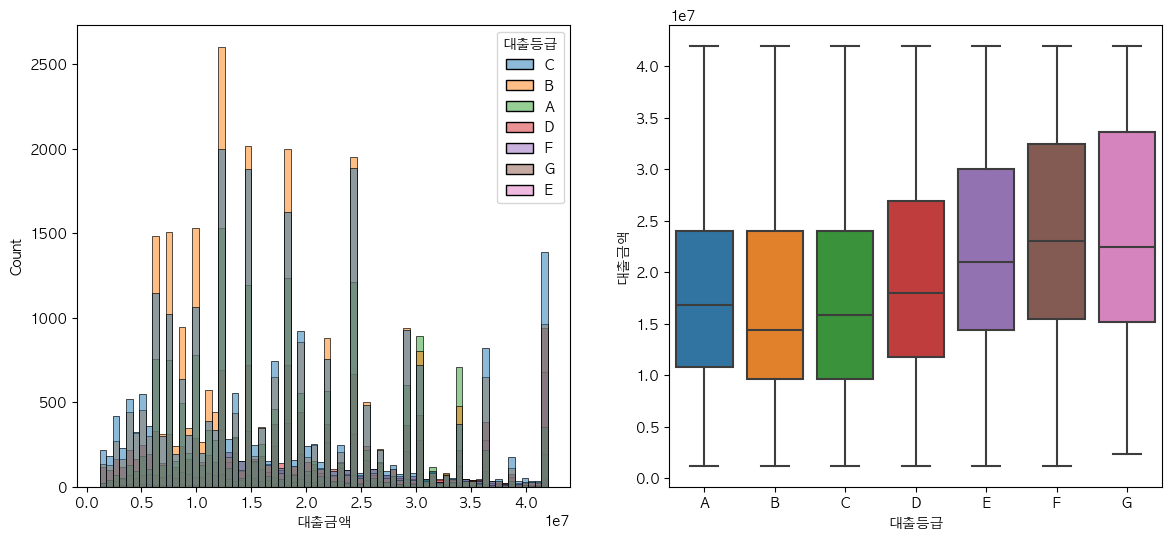

,mean,std,min,25%,50%,75%,max
A,1.790579e+07,9.294000e+06,1200000.0,10800000.0,16800000.0,24000000.0,42000000.0
B,1.686808e+07,9.772310e+06,1200000.0,9600000.0,14400000.0,24000000.0,42000000.0
C,1.789004e+07,1.052509e+07,1200000.0,9600000.0,15840000.0,24000000.0,42000000.0
D,1.953331e+07,1.097276e+07,1200000.0,11730000.0,18000000.0,26880000.0,42000000.0
E,2.232013e+07,1.077465e+07,1200000.0,14340000.0,21000000.0,30000000.0,42000000.0
F,2.400517e+07,1.061245e+07,1200000.0,15480000.0,23040000.0,32422500.0,42000000.0
G,2.402079e+07,1.080393e+07,2310000.0,15120000.0,22440000.0,33600000.0,42000000.0


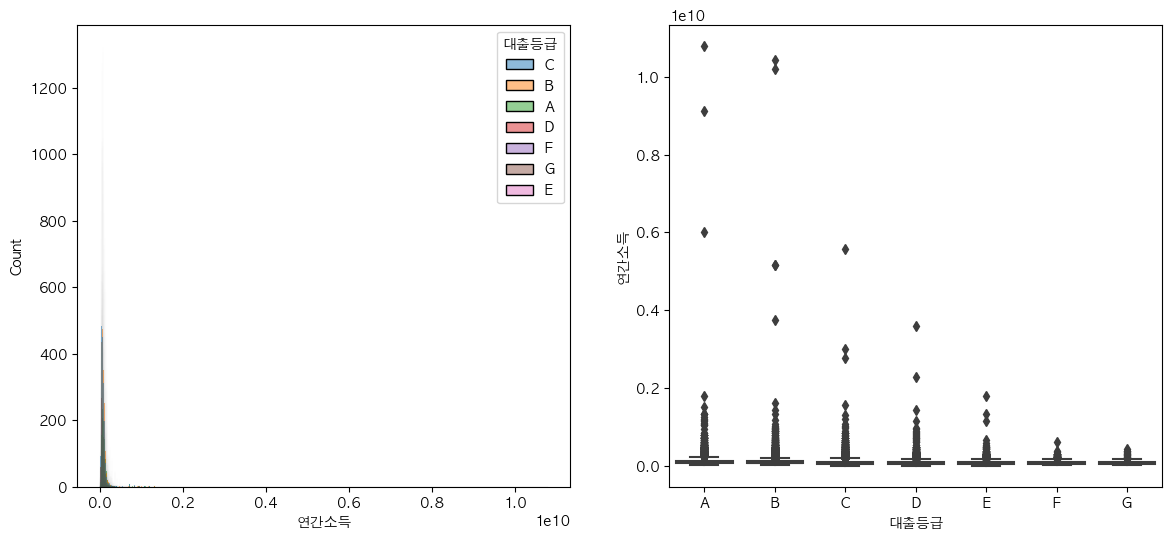

,mean,std,min,25%,50%,75%,max
A,1.124911e+08,1.396115e+08,11424000.0,67200000.0,96000000.0,132000000.0,1.080000e+10
B,9.570640e+07,1.160385e+08,9600000.0,58386000.0,81600000.0,114000000.0,1.044000e+10
C,8.903804e+07,7.227919e+07,0.0,54000000.0,75600000.0,108000000.0,5.576640e+09
D,8.359673e+07,6.622318e+07,2124000.0,51454800.0,72000000.0,100800000.0,3.600000e+09
E,8.492864e+07,5.582495e+07,1440000.0,54000000.0,73200000.0,102000000.0,1.800000e+09
F,8.434506e+07,4.500624e+07,10627200.0,54000000.0,75430800.0,102000000.0,6.000000e+08
G,8.258034e+07,5.407082e+07,10555200.0,50400000.0,70800000.0,96000000.0,4.344000e+08


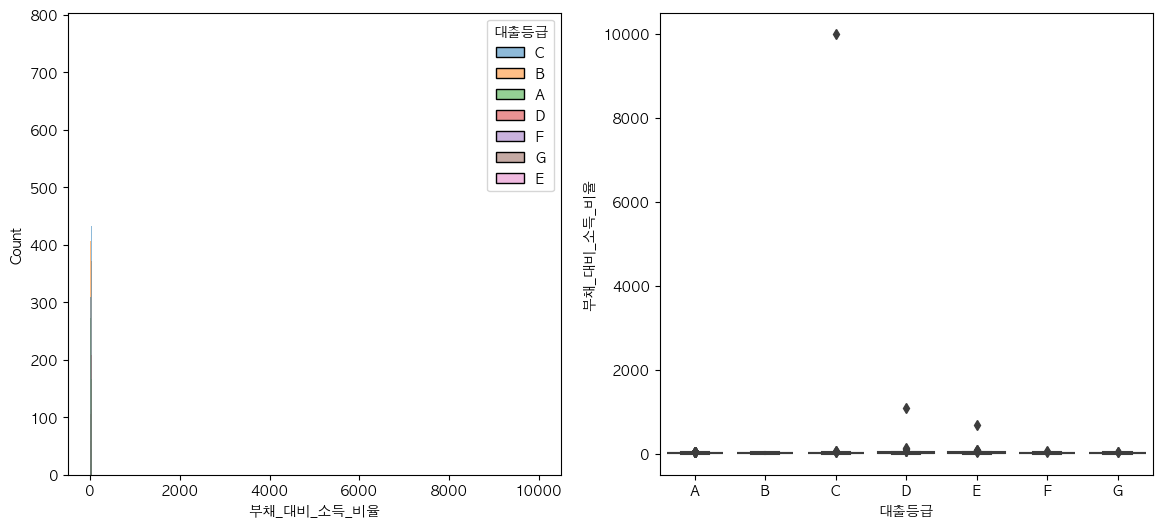

,mean,std,min,25%,50%,75%,max
A,16.547850,7.558913,0.00,10.8200,16.130,21.8700,39.80
B,18.129529,8.191684,0.00,11.9300,17.600,23.9800,41.69
C,20.270095,60.681872,0.00,13.3000,19.510,26.3050,9999.00
D,21.808465,13.166067,0.00,14.6900,21.610,29.1575,1092.52
E,22.248466,11.977395,0.16,15.3500,21.925,29.2875,672.52
F,21.853710,8.913153,0.66,15.3925,22.125,28.3375,54.36
G,20.691952,8.718104,0.82,14.3525,21.095,26.5350,47.61


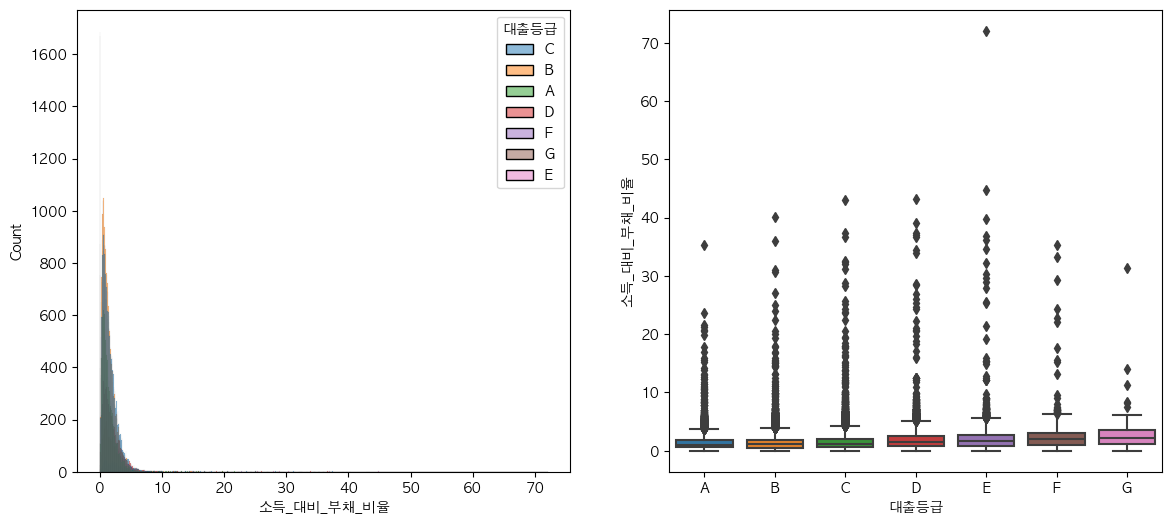

,mean,std,min,25%,50%,75%,max
A,1.340228,1.236461,0.0,0.556977,1.048406,1.833485,35.331951
B,1.362959,1.269665,0.0,0.551857,1.077833,1.871536,40.196385
C,inf,NaN,0.0,0.604202,1.186426,2.069456,inf
D,1.818266,1.788255,0.0,0.733820,1.451041,2.498630,43.293415
E,2.014130,2.113852,0.0,0.887124,1.660378,2.746429,72.097500
F,2.269860,2.137192,0.0,1.005051,1.985169,3.102620,35.280524
G,2.523636,2.246711,0.0,1.105443,2.193720,3.604028,31.397686


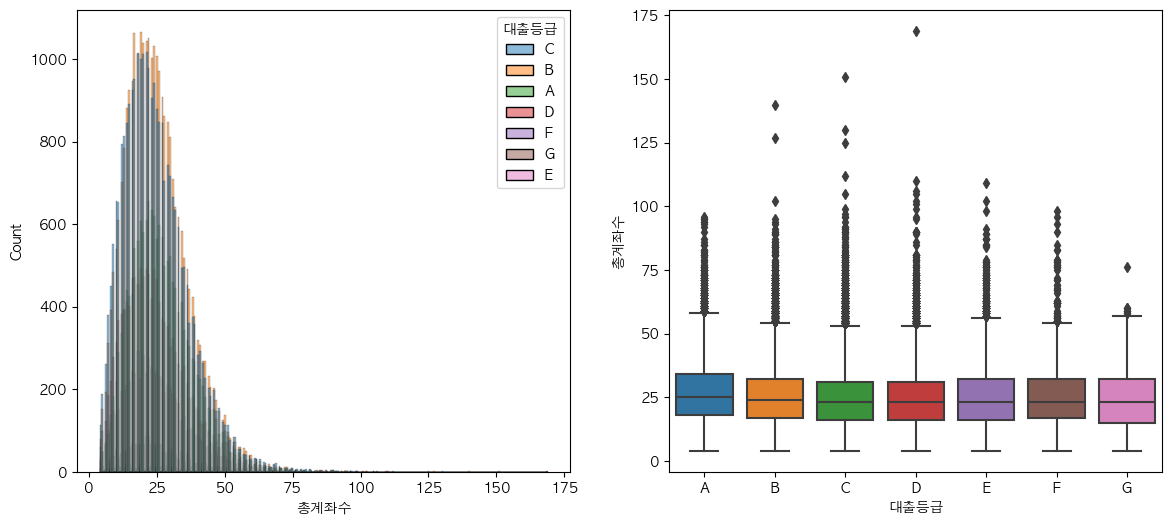

,mean,std,min,25%,50%,75%,max
A,26.910684,11.788615,4.0,18.0,25.0,34.0,96.0
B,25.223375,11.765557,4.0,17.0,24.0,32.0,140.0
C,24.695073,12.195646,4.0,16.0,23.0,31.0,151.0
D,24.705107,12.357153,4.0,16.0,23.0,31.0,169.0
E,25.320642,12.522195,4.0,16.0,23.0,32.0,109.0
F,25.543501,12.950036,4.0,17.0,23.0,32.0,98.0
G,24.550000,12.482346,4.0,15.0,23.0,32.0,76.0


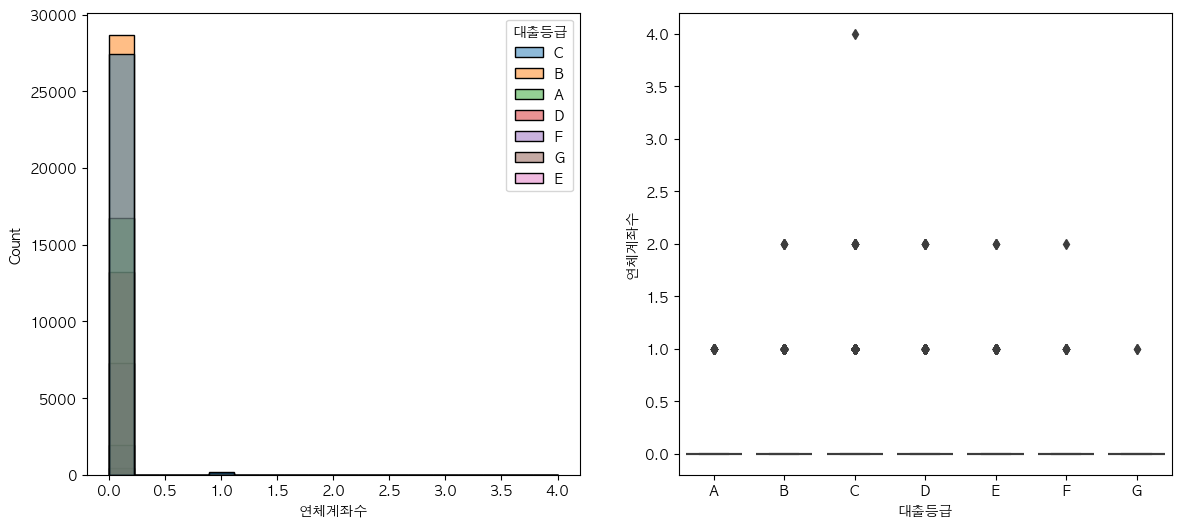

,mean,std,min,25%,50%,75%,max
A,0.001133,0.033640,0.0,0.0,0.0,0.0,1.0
B,0.004789,0.071019,0.0,0.0,0.0,0.0,2.0
C,0.007892,0.094808,0.0,0.0,0.0,0.0,4.0
D,0.008462,0.096382,0.0,0.0,0.0,0.0,2.0
E,0.007615,0.091509,0.0,0.0,0.0,0.0,2.0
F,0.006653,0.087385,0.0,0.0,0.0,0.0,2.0
G,0.004762,0.068924,0.0,0.0,0.0,0.0,1.0


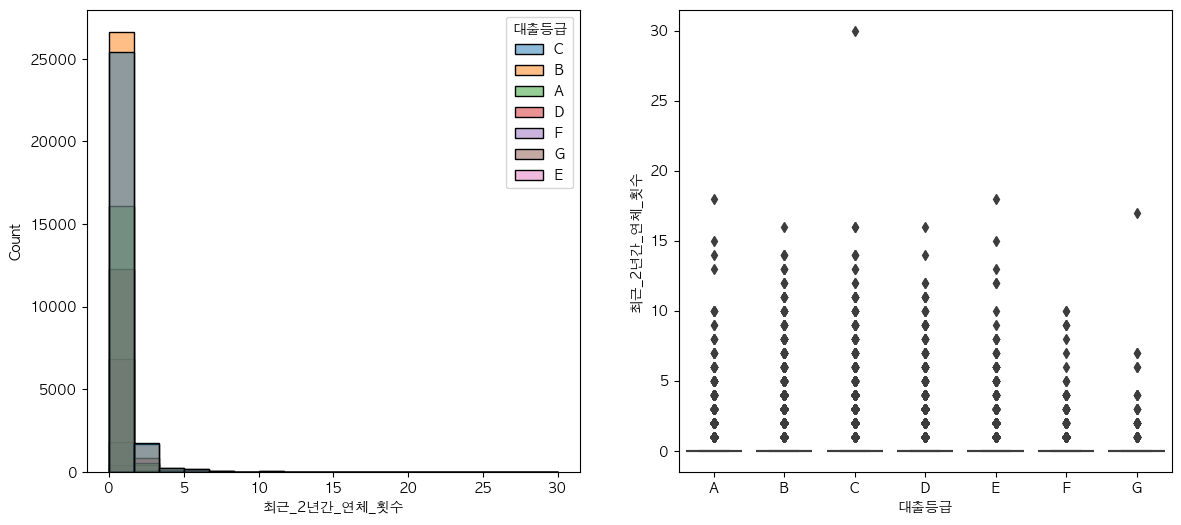

,mean,std,min,25%,50%,75%,max
A,0.218698,0.704163,0.0,0.0,0.0,0.0,18.0
B,0.365409,0.947582,0.0,0.0,0.0,0.0,16.0
C,0.380299,0.966606,0.0,0.0,0.0,0.0,30.0
D,0.384379,0.970777,0.0,0.0,0.0,0.0,16.0
E,0.349334,0.914513,0.0,0.0,0.0,0.0,18.0
F,0.361822,0.914466,0.0,0.0,0.0,0.0,10.0
G,0.416667,1.239835,0.0,0.0,0.0,0.0,17.0


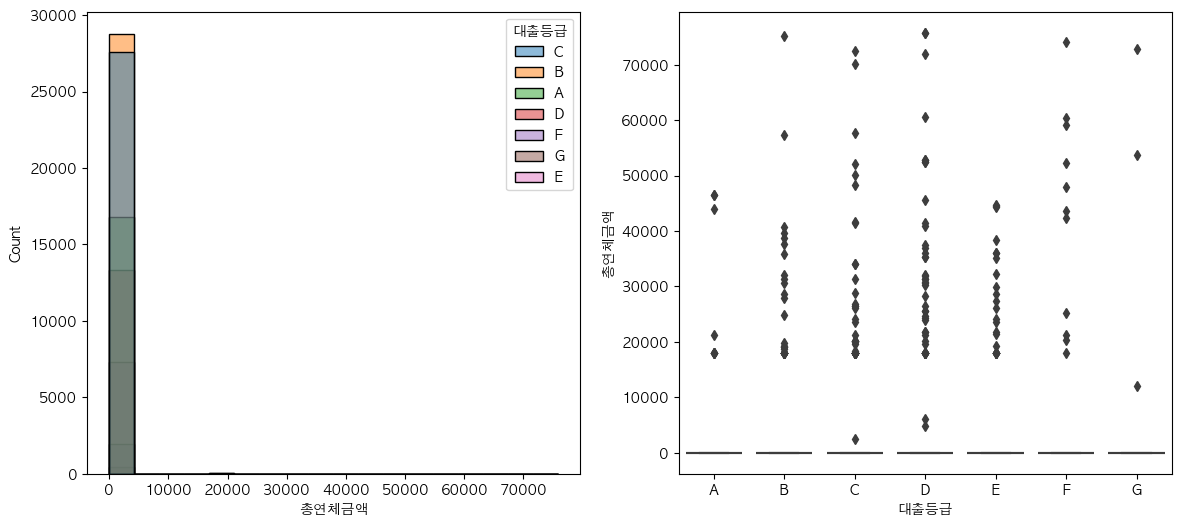

,mean,std,min,25%,50%,75%,max
A,14.806105,704.850463,0.0,0.0,0.0,0.0,46536.0
B,29.441371,983.715162,0.0,0.0,0.0,0.0,75216.0
C,48.052565,1258.793440,0.0,0.0,0.0,0.0,72444.0
D,113.352104,2127.823877,0.0,0.0,0.0,0.0,75768.0
E,94.572206,1678.616326,0.0,0.0,0.0,0.0,44688.0
F,237.801433,3437.789928,0.0,0.0,0.0,0.0,74076.0
G,329.942857,4448.705070,0.0,0.0,0.0,0.0,72864.0


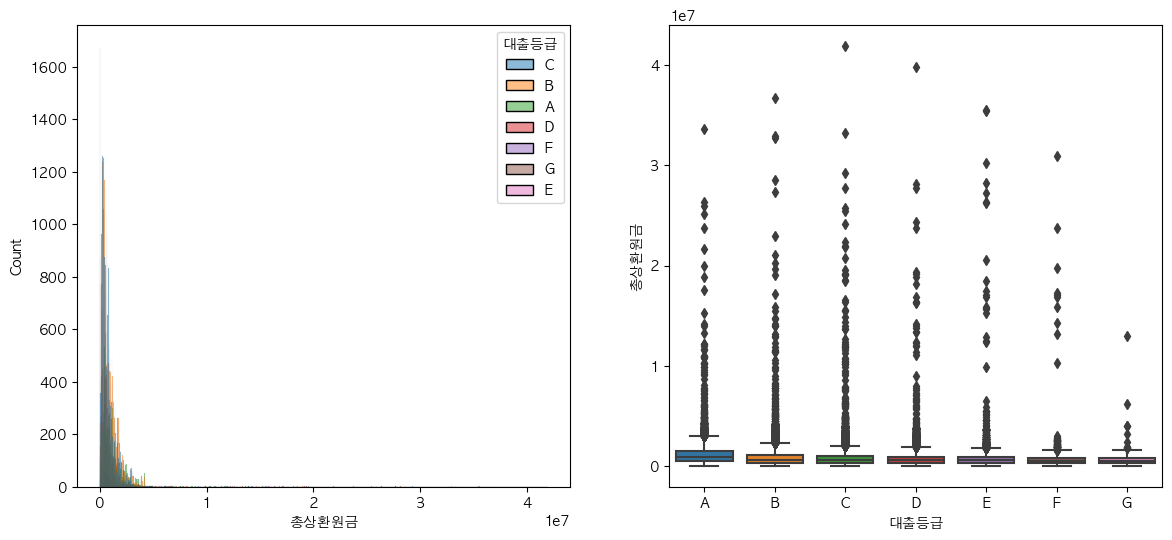

,mean,std,min,25%,50%,75%,max
A,1.066966e+06,1.076776e+06,0.0,444804.0,830280.0,1441248.0,33683988.0
B,8.340144e+05,9.403085e+05,0.0,318336.0,606564.0,1101888.0,36721164.0
C,7.521078e+05,9.753910e+05,0.0,278616.0,552132.0,963672.0,41955936.0
D,7.297173e+05,1.018910e+06,0.0,267948.0,528600.0,908784.0,39793896.0
E,7.074507e+05,1.238723e+06,0.0,288672.0,523908.0,872802.0,35550000.0
F,6.673177e+05,1.368616e+06,0.0,267030.0,490224.0,794940.0,30911292.0
G,5.870190e+05,8.149610e+05,0.0,229296.0,442188.0,764745.0,12937416.0


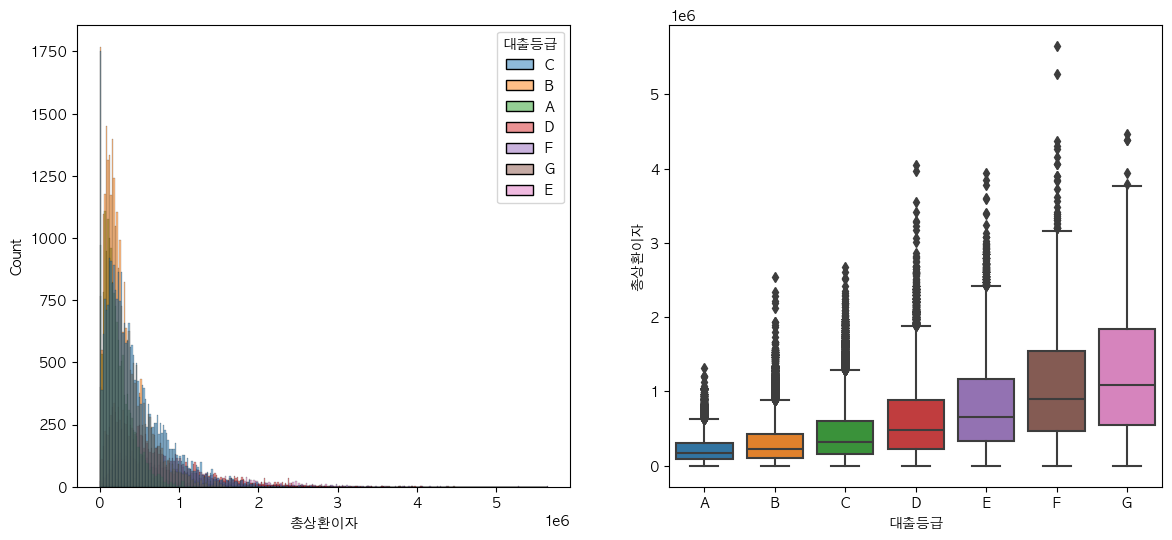

,mean,std,min,25%,50%,75%,max
A,2.240085e+05,183508.609726,0.0,91401.0,175632.0,306678.0,1315908.0
B,3.033410e+05,268912.292532,0.0,110652.0,222228.0,421008.0,2538084.0
C,4.306745e+05,377468.910481,0.0,154560.0,323028.0,607092.0,2671956.0
D,6.117896e+05,520056.028372,0.0,220875.0,474684.0,884532.0,4048740.0
E,8.146975e+05,627671.231203,0.0,338886.0,653004.0,1168896.0,3942252.0
F,1.095274e+06,819704.001437,0.0,470883.0,900930.0,1548396.0,5653416.0
G,1.284655e+06,952955.115509,0.0,549405.0,1089972.0,1844562.0,4464612.0


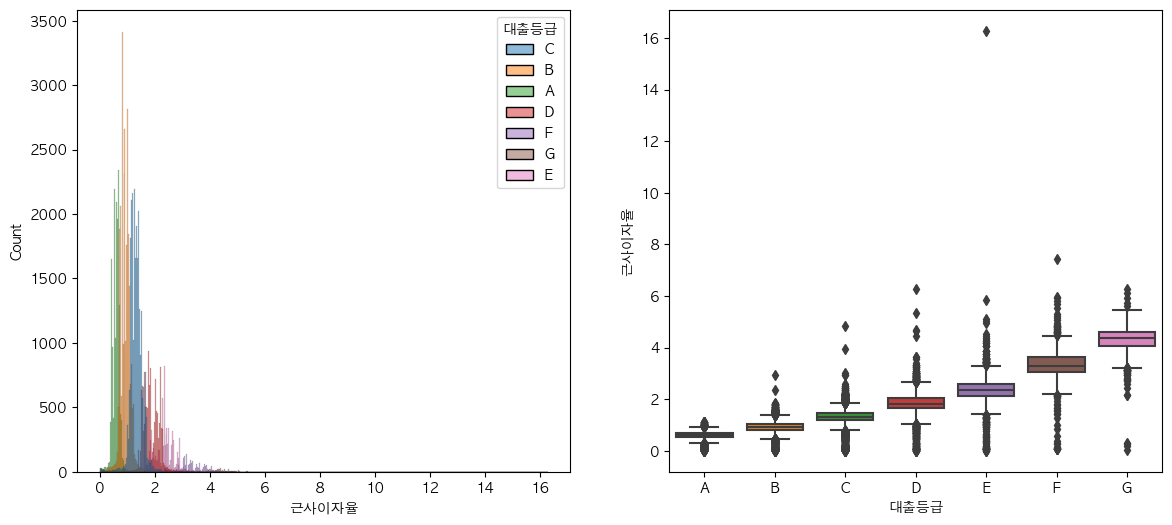

,mean,std,min,25%,50%,75%,max
A,0.589243,0.118483,0.000000,0.523619,0.604855,0.680202,1.124066
B,inf,NaN,0.000000,0.805299,0.913733,1.031782,inf
C,inf,NaN,0.000000,1.182412,1.318237,1.445302,inf
D,1.849207,0.322837,0.000000,1.655197,1.814671,2.060453,6.262837
E,2.346944,0.435691,0.000000,2.119561,2.339977,2.595898,16.287093
F,inf,NaN,0.055156,3.047362,3.292409,3.619552,inf
G,inf,NaN,0.032156,4.055050,4.358342,4.615506,inf


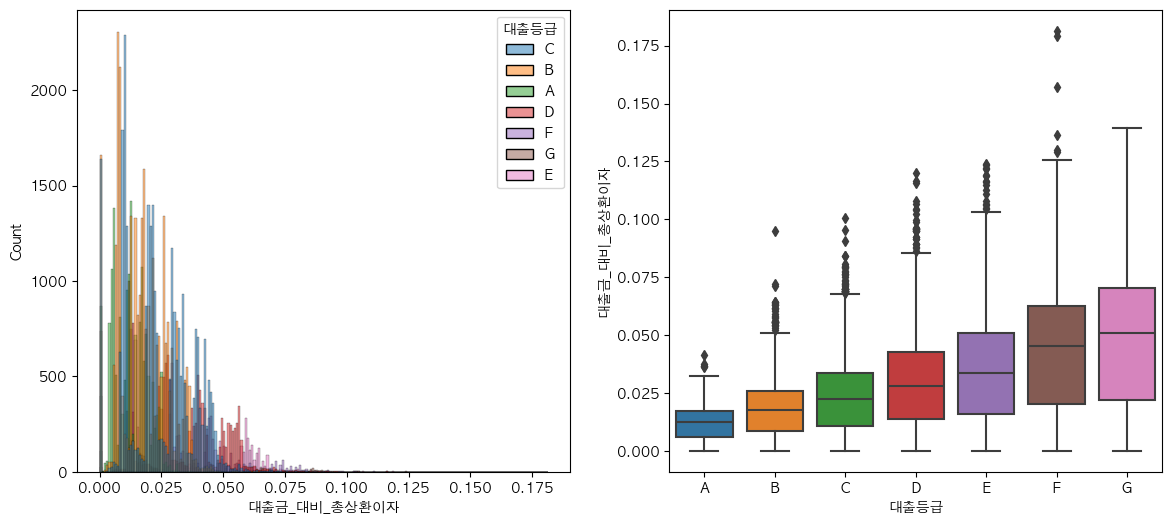

,mean,std,min,25%,50%,75%,max
A,0.012414,0.006792,0.0,0.006137,0.012219,0.017293,0.041269
B,0.017697,0.009932,0.0,0.008547,0.017490,0.025604,0.094911
C,0.023874,0.013314,0.0,0.010632,0.022154,0.033634,0.100353
D,0.031217,0.017358,0.0,0.013666,0.028153,0.042706,0.120203
E,0.036467,0.019927,0.0,0.015743,0.033647,0.050804,0.123920
F,0.045236,0.025082,0.0,0.020027,0.045168,0.062477,0.181466
G,0.052082,0.028765,0.0,0.022041,0.051010,0.070512,0.139385


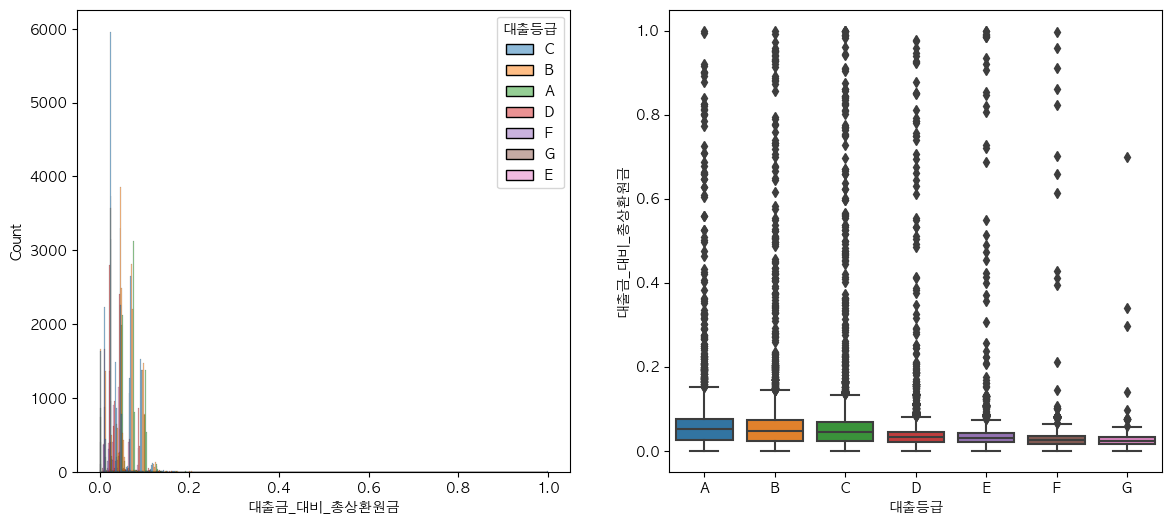

,mean,std,min,25%,50%,75%,max
A,0.060125,0.048775,0.0,0.025682,0.050795,0.076390,1.000000
B,0.051463,0.045263,0.0,0.024238,0.048074,0.072413,0.999773
C,0.045299,0.047021,0.0,0.023005,0.044845,0.067689,1.000000
D,0.040775,0.046881,0.0,0.021296,0.032909,0.045287,0.977581
E,0.034178,0.049870,0.0,0.019824,0.029984,0.041900,1.000000
F,0.029405,0.056080,0.0,0.016732,0.026098,0.036118,0.997954
G,0.025777,0.041796,0.0,0.015339,0.023624,0.032429,0.700077


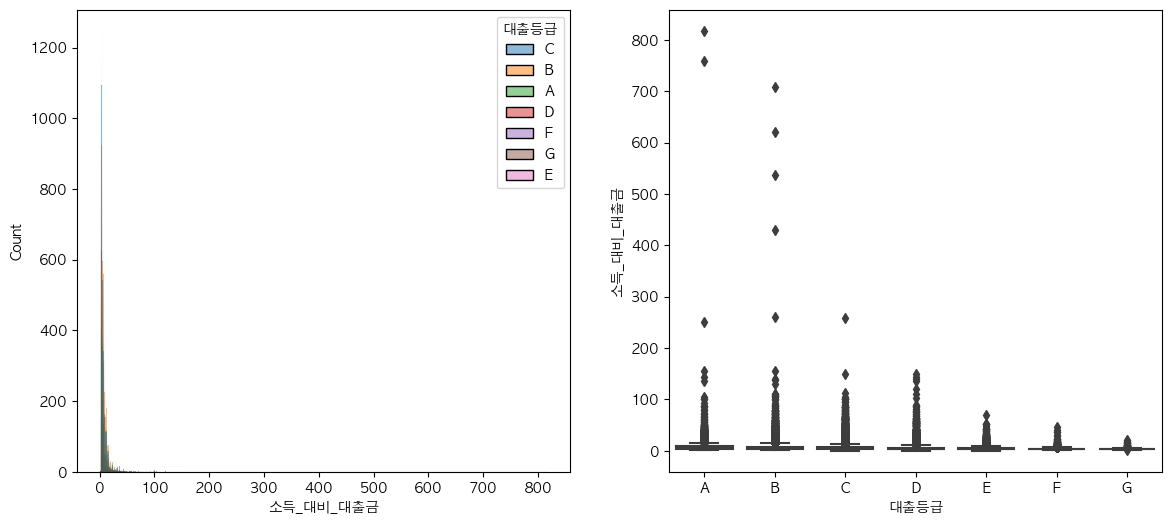

,mean,std,min,25%,50%,75%,max
A,7.597494,10.685901,2.000000,4.166667,5.833333,8.666667,818.181818
B,7.397491,9.842444,1.733333,3.755102,5.357143,8.160000,708.335083
C,6.805572,7.329962,0.000000,3.333333,4.666667,7.272727,258.177778
D,5.920238,7.026040,0.270229,2.809622,3.833333,6.142857,150.000000
E,4.548797,3.872436,0.100000,2.685714,3.373590,4.907943,70.000000
F,4.013692,2.979861,1.276596,2.632104,3.166667,4.310920,47.000000
G,3.720195,2.306908,0.561148,2.631579,3.070239,3.907221,20.482375


In [28]:
list_num = ['대출금액', '연간소득', '부채_대비_소득_비율', '소득_대비_부채_비율',
            '총계좌수', '연체계좌수', '최근_2년간_연체_횟수', '총연체금액',
            '총상환원금', '총상환이자', '근사이자율', 
            '대출금_대비_총상환이자', '대출금_대비_총상환원금', '소득_대비_대출금']

for col in list_num:    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
    sns.histplot(data=train, x=col, hue='대출등급', ax=ax[0])
    sns.boxplot(data=train, y=col, x='대출등급', order=hue_order, ax=ax[1])
    plt.show()
    num_statistic(train, col)

# Re-Preprocessing

## To NaN

In [29]:
cond = (train['연간소득']==0)
train.loc[cond, '연간소득'] = np.nan

cond = (test['연간소득']==0)
test.loc[cond, '연간소득'] = np.nan

cond = (train['부채_대비_소득_비율']==0)
train.loc[cond, '부채_대비_소득_비율'] = np.nan

cond = (test['부채_대비_소득_비율']==0)
test.loc[cond, '부채_대비_소득_비율'] = np.nan

In [30]:
cond = (train['총상환원금']==0)
train.loc[cond, '총상환원금'] = np.nan

cond = (train['총상환이자']==0)
train.loc[cond, '총상환이자'] = np.nan

cond = (train['근사이자율']==0)
train.loc[cond, '근사이자율'] = np.nan

cond = (train['근사이자율']==np.inf)
train.loc[cond, '근사이자율'] = np.nan

cond = (test['총상환원금']==0)
test.loc[cond, '총상환원금'] = np.nan

cond = (test['총상환이자']==0)
test.loc[cond, '총상환이자'] = np.nan

cond = (test['근사이자율']==0)
test.loc[cond, '근사이자율'] = np.nan

cond = (test['근사이자율']==np.inf)
test.loc[cond, '근사이자율'] = np.nan

In [31]:
cond = (train['소득_대비_부채_비율']==0)
train.loc[cond, '소득_대비_부채_비율'] = np.nan

cond = (test['소득_대비_부채_비율']==0)
test.loc[cond, '소득_대비_부채_비율'] = np.nan

cond = (train['소득_대비_부채_비율']==np.inf)
train.loc[cond, '소득_대비_부채_비율'] = np.nan

cond = (test['소득_대비_부채_비율']==np.inf)
test.loc[cond, '소득_대비_부채_비율'] = np.nan

cond = (train['총상환원금']==0)
train.loc[cond, '소득_대비_부채_비율'] = np.nan

cond = (test['총상환원금']==0)
test.loc[cond, '소득_대비_부채_비율'] = np.nan

cond = (train['총상환이자']==0)
train.loc[cond, '소득_대비_부채_비율'] = np.nan

cond = (test['총상환이자']==0)
test.loc[cond, '소득_대비_부채_비율'] = np.nan

In [32]:
cond = (train['대출금_대비_총상환원금']==0)
train.loc[cond, '대출금_대비_총상환원금'] = np.nan

cond = (test['대출금_대비_총상환원금']==0)
test.loc[cond, '대출금_대비_총상환원금'] = np.nan

cond = (train['대출금_대비_총상환이자']==0)
train.loc[cond, '대출금_대비_총상환이자'] = np.nan

cond = (test['대출금_대비_총상환이자']==0)
test.loc[cond, '대출금_대비_총상환이자'] = np.nan

In [33]:
cond = (train['연체계좌수']==0) & (train['총연체금액']!=0)
train.loc[cond, '연체계좌수'] = np.nan

cond = (test['연체계좌수']==0) & (test['총연체금액']!=0)
test.loc[cond, '연체계좌수'] = np.nan

cond = (train['연체계좌수']!=0) & (train['총연체금액']==0)
train.loc[cond, '총연체금액'] = np.nan

cond = (test['연체계좌수']!=0) & (test['총연체금액']==0)
test.loc[cond, '총연체금액'] = np.nan

In [34]:
cond = (train['최근_2년간_연체_횟수']==0) & (train['총연체금액']!=0)
train.loc[cond, '최근_2년간_연체_횟수'] = np.nan

cond = (test['최근_2년간_연체_횟수']==0) & (test['총연체금액']!=0)
test.loc[cond, '최근_2년간_연체_횟수'] = np.nan

cond = (train['연체계좌수']!=0) & (train['최근_2년간_연체_횟수']==0)
train.loc[cond, '최근_2년간_연체_횟수'] = np.nan

cond = (test['연체계좌수']!=0) & (test['최근_2년간_연체_횟수']==0)
test.loc[cond, '최근_2년간_연체_횟수'] = np.nan

## Remove Outlier

In [35]:
cond_out1 = (train['연간소득']==0) & (train['대출등급']=='C')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

In [36]:
cond_out1 = (train['부채_대비_소득_비율']>=600)
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

In [37]:
cond_out1 = (train['소득_대비_부채_비율']>=30) & (train['대출등급']=='A')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['소득_대비_부채_비율']>=60) & (train['대출등급']=='E')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

In [38]:
# cond_out1 = (train['총상환원금']>=40000000) & (train['대출등급']=='C')
# drop_index_1 = train.loc[cond_out1].index

# train.drop(drop_index_1, axis=0, inplace=True)

# cond_out1 = (train['총상환원금']>=30000000) & (train['대출등급']=='D')
# drop_index_1 = train.loc[cond_out1].index

# train.drop(drop_index_1, axis=0, inplace=True)

# cond_out1 = (train['총상환원금']>=30000000) & (train['대출등급']=='E')
# drop_index_1 = train.loc[cond_out1].index

# train.drop(drop_index_1, axis=0, inplace=True)

# cond_out1 = (train['총상환원금']>=30000000) & (train['대출등급']=='F')
# drop_index_1 = train.loc[cond_out1].index

# train.drop(drop_index_1, axis=0, inplace=True)

# cond_out1 = (train['총상환원금']>=10000000) & (train['대출등급']=='G')
# drop_index_1 = train.loc[cond_out1].index

# train.drop(drop_index_1, axis=0, inplace=True)

In [39]:
cond_out1 = (train['총상환원금']>=36000000) & (train['대출등급']=='B')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['총상환원금']>=30000000) & (train['대출등급']=='C')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['총상환원금']>=30000000) & (train['대출등급']=='D')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['총상환원금']>=22000000) & (train['대출등급']=='E')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['총상환원금']>=22000000) & (train['대출등급']=='F')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['총상환원금']>=10000000) & (train['대출등급']=='G')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

In [40]:
cond_out1 = (train['총상환이자']>=5000000) & (train['대출등급']=='F')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['총상환이자']>=3900000) & (train['대출등급']=='D')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

In [41]:
cond_out1 = (train['근사이자율']>=6) & (train['대출등급']=='F')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['근사이자율']>=5.8) & (train['대출등급']=='E')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['근사이자율']>=4) & (train['대출등급']=='D')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['근사이자율']>=3.9) & (train['대출등급']=='C')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['근사이자율']>=2.3) & (train['대출등급']=='B')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['근사이자율']<=1) & (train['대출등급']=='G')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

In [42]:
cond_out1 = (train['대출금_대비_총상환원금']>=0.20) & (train['대출등급']=='G')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

In [43]:
cond_out1 = (train['대출금_대비_총상환이자']>=0.130) & (train['대출등급']=='F')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

In [44]:
cond_out1 = (train['최근_2년간_연체_횟수']==30) & (train['대출등급']=='C')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['최근_2년간_연체_횟수']==18) & (train['대출등급']=='A')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['최근_2년간_연체_횟수']==15) & (train['대출등급']=='A')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['최근_2년간_연체_횟수']==14) & (train['대출등급']=='A')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

cond_out1 = (train['최근_2년간_연체_횟수']==13) & (train['대출등급']=='A')
drop_index_1 = train.loc[cond_out1].index

train.drop(drop_index_1, axis=0, inplace=True)

# Impute

## 근사이자율

In [45]:
impute_train = train.copy()
impute_test = test.copy()

In [46]:
impute_train['대출기간'] = impute_train['대출기간'].astype('category')
impute_train['주택소유상태'] = impute_train['주택소유상태'].astype('category')
impute_train['대출목적'] = impute_train['대출목적'].astype('category')
impute_train['근속기간'] = impute_train['근속기간'].astype('category')
impute_train['연체여부'] = impute_train['연체여부'].astype('category')

impute_test['대출기간'] = impute_test['대출기간'].astype('category')
impute_test['주택소유상태'] = impute_test['주택소유상태'].astype('category')
impute_test['대출목적'] = impute_test['대출목적'].astype('category')
impute_test['근속기간'] = impute_test['근속기간'].astype('category')
impute_test['연체여부'] = impute_test['연체여부'].astype('category')

In [47]:
IMPUTE_TRAIN_TRAIN = impute_train[impute_train['근사이자율'].notnull()]
IMPUTE_TRAIN_TEST = impute_train[impute_train['근사이자율'].isnull()]

IMPUTE_TEST_TRAIN = impute_test[impute_test['근사이자율'].notnull()]
IMPUTE_TEST_TEST = impute_test[impute_test['근사이자율'].isnull()]

In [48]:
use_impute_feature = ['대출금액', '대출기간', '주택소유상태', '연간소득', '부채_대비_소득_비율','대출목적',
                      '최근_2년간_연체_횟수', '총연체금액', '연체계좌수', '연체여부',
                      '근속기간', '소득_대비_대출금']

X_impute_train_train = IMPUTE_TRAIN_TRAIN[use_impute_feature]
y_impute_train_train = IMPUTE_TRAIN_TRAIN[['근사이자율']]

X_impute_train_test = IMPUTE_TRAIN_TEST[use_impute_feature]
y_impute_train_test = IMPUTE_TRAIN_TEST[['근사이자율']]

X_impute_test_test = IMPUTE_TEST_TEST[use_impute_feature]
y_impute_test_test = IMPUTE_TEST_TEST[['근사이자율']]

In [49]:
print(X_impute_train_train.shape, y_impute_train_train.shape)
print(X_impute_train_test.shape, y_impute_train_test.shape)
print(X_impute_test_test.shape, y_impute_test_test.shape)

(90801, 12) (90801, 1)
(5448, 12) (5448, 1)
(3533, 12) (3533, 1)


In [50]:
print(y_impute_train_train.isnull().sum())
print(y_impute_train_test.isnull().sum())
print(y_impute_test_test.isnull().sum())

근사이자율    0
dtype: int64
근사이자율    5448
dtype: int64
근사이자율    3533
dtype: int64


In [51]:
X_IMPUTE_TRAIN, X_IMPUTE_VALID, y_IMPUTE_TRAIN, y_IMPUTE_VALID = train_test_split(X_impute_train_train,
                                                                                  y_impute_train_train,
                                                                                  test_size=0.30, 
                                                                                  random_state=42)

In [52]:
imputer = XGBRegressor(max_depth=3,
                      n_estimators=5000,
                      learning_rate=0.05,
                      missing=np.nan,
                      tree_method="approx",
                      objective='reg:squaredlogerror',
                      eval_metric='mae',
                      enable_categorical=True,
                      early_stopping_rounds=20,
                      colsample_bytree=0.8,
                      colsample_bylevel=0.8,
                      subsample=1.0,
                      gamma=0,
                      seed=42,
                      )

In [53]:
imputer.fit(X_IMPUTE_TRAIN, y_IMPUTE_TRAIN,
            eval_set=[(X_IMPUTE_VALID, y_IMPUTE_VALID)],
            verbose=300)

[0]	validation_0-mae:0.77054
[300]	validation_0-mae:0.35517
[600]	validation_0-mae:0.35054
[900]	validation_0-mae:0.34879
[1053]	validation_0-mae:0.34829


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None, colsample_bytree=0.8,
             early_stopping_rounds=20, enable_categorical=True,
             eval_metric='mae', feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             objective='reg:squaredlogerror', predictor=None, ...)

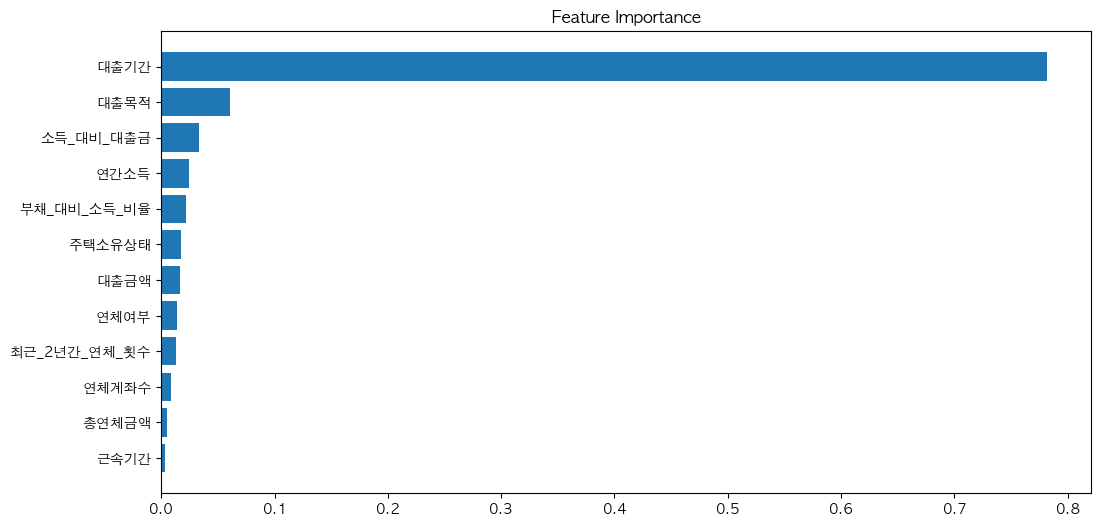

In [54]:
feature_importance = imputer.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_IMPUTE_VALID.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [55]:
IMPUTE_TRAIN_TEST['근사이자율'] = imputer.predict(X_impute_train_test)
IMPUTE_TEST_TEST['근사이자율'] = imputer.predict(X_impute_test_test)

In [56]:
train = pd.concat([IMPUTE_TRAIN_TRAIN, IMPUTE_TRAIN_TEST], axis=0).sort_values(by='ID')
test = pd.concat([IMPUTE_TEST_TRAIN, IMPUTE_TEST_TEST], axis=0).sort_values(by='ID')

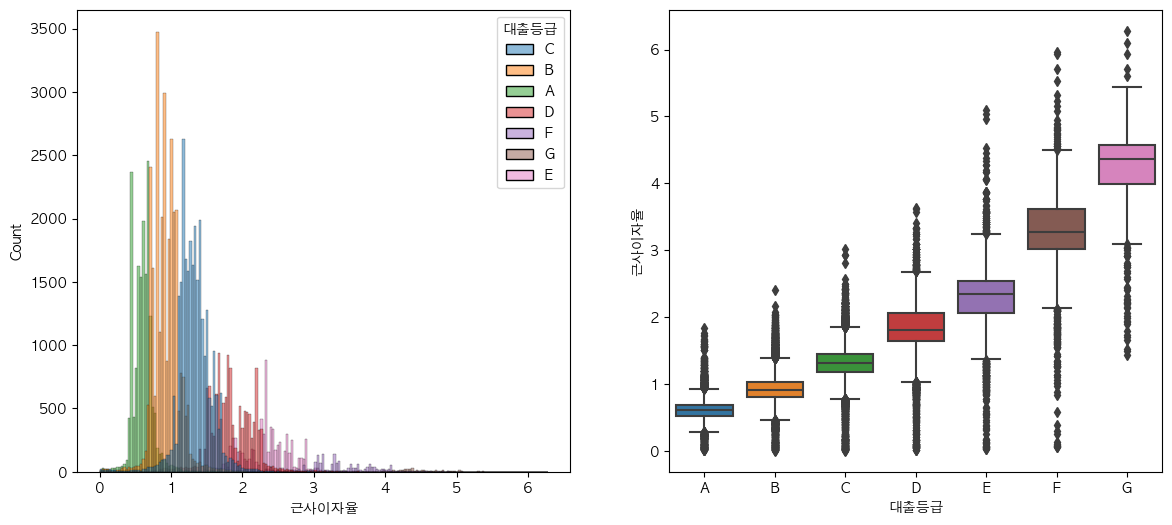

,mean,std,min,25%,50%,75%,max
A,0.605811,0.141527,0.007186,0.525371,0.615498,0.688166,1.830074
B,0.929330,0.187335,0.003883,0.806124,0.913789,1.036386,2.398517
C,1.327305,0.229859,0.002560,1.180020,1.312015,1.447118,3.025134
D,1.829400,0.328891,0.008752,1.648599,1.812388,2.060363,3.632520
E,2.314515,0.415707,0.028835,2.063071,2.339294,2.534327,5.094525
F,3.216145,0.659634,0.055156,3.019062,3.275591,3.609278,5.960750
G,4.135394,0.795997,1.440875,3.983144,4.358213,4.579130,6.281402


In [57]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
sns.histplot(data=train, x='근사이자율', hue='대출등급', ax=ax[0])
sns.boxplot(data=train, y='근사이자율', x='대출등급', order=hue_order, ax=ax[1])
plt.show()
num_statistic(train, '근사이자율')

# Set Dataset

In [67]:
train['대출기간'] = train['대출기간'].astype('category')
train['주택소유상태'] = train['주택소유상태'].astype('category')
train['대출목적'] = train['대출목적'].astype('category')
train['근속기간'] = train['근속기간'].astype('category')
train['연체여부'] = train['연체여부'].astype('category')

test['대출기간'] = test['대출기간'].astype('category')
test['주택소유상태'] = test['주택소유상태'].astype('category')
test['대출목적'] = test['대출목적'].astype('category')
test['근속기간'] = test['근속기간'].astype('category')
test['연체여부'] = test['연체여부'].astype('category')

In [68]:
train_X = train.drop(columns=['대출등급', 'ID'])
train_y = train[['대출등급']]

X_test = test.drop(columns=['ID'])

In [69]:
use_features = [
                '대출기간', '대출목적', '주택소유상태', '근속기간',
                '근사이자율', '대출금_대비_총상환이자', '대출금_대비_총상환원금',
                '소득_대비_대출금', '부채_대비_소득_비율', '소득_대비_부채_비율', 
                '연체여부', '연체계좌수',  '최근_2년간_연체_횟수', '총연체금액', 
                ]

train_X = train[use_features]
X_test = test[use_features]

In [70]:
encoder = LabelEncoder()
train_y['대출등급'] = encoder.fit_transform(train_y['대출등급'])

# Cross-Validation

[0]	validation_0-mlogloss:1.81558
[200]	validation_0-mlogloss:0.14657
[400]	validation_0-mlogloss:0.12293
[576]	validation_0-mlogloss:0.12121


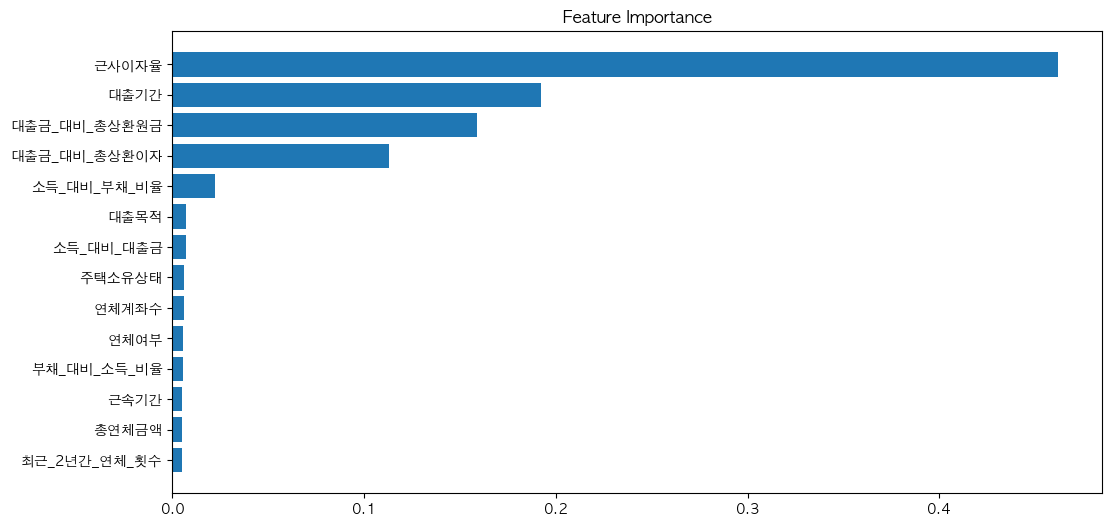

0-Fold F1-Score : 0.9417005202309426
              precision    recall  f1-score   support

           0      0.963     0.960     0.962      3353
           1      0.945     0.959     0.952      5763
           2      0.944     0.957     0.951      5524
           3      0.969     0.939     0.954      2669
           4      0.962     0.938     0.950      1469
           5      0.951     0.900     0.925       389
           6      0.947     0.855     0.899        83

    accuracy                          0.953     19250
   macro avg      0.955     0.930     0.942     19250
weighted avg      0.953     0.953     0.953     19250

[0]	validation_0-mlogloss:1.81542
[200]	validation_0-mlogloss:0.14470
[400]	validation_0-mlogloss:0.12077
[600]	validation_0-mlogloss:0.11789
[716]	validation_0-mlogloss:0.11760


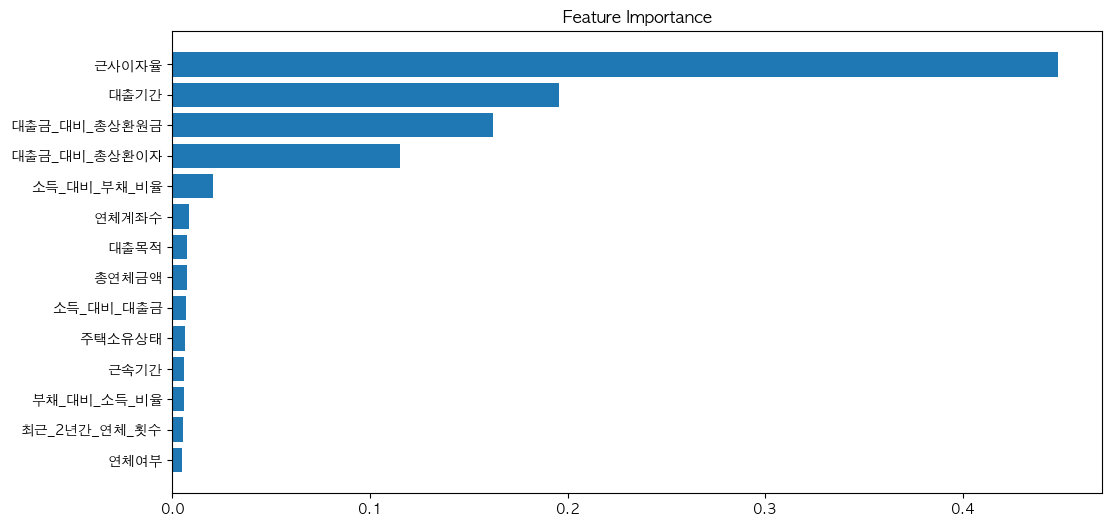

1-Fold F1-Score : 0.9433042649058823
              precision    recall  f1-score   support

           0      0.962     0.949     0.955      3354
           1      0.940     0.962     0.951      5762
           2      0.946     0.957     0.951      5524
           3      0.971     0.939     0.954      2669
           4      0.969     0.941     0.955      1469
           5      0.944     0.913     0.928       389
           6      0.925     0.892     0.908        83

    accuracy                          0.952     19250
   macro avg      0.951     0.936     0.943     19250
weighted avg      0.952     0.952     0.952     19250

[0]	validation_0-mlogloss:1.81551
[200]	validation_0-mlogloss:0.14036
[400]	validation_0-mlogloss:0.11716
[600]	validation_0-mlogloss:0.11482
[628]	validation_0-mlogloss:0.11480


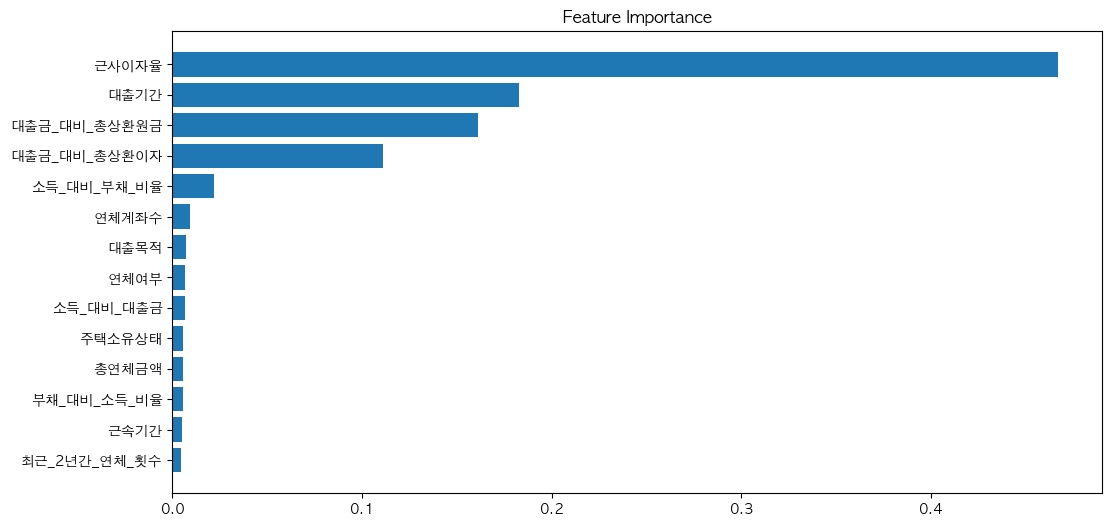

2-Fold F1-Score : 0.942047590663077
              precision    recall  f1-score   support

           0      0.970     0.961     0.965      3354
           1      0.945     0.965     0.955      5763
           2      0.946     0.959     0.953      5523
           3      0.969     0.937     0.953      2669
           4      0.974     0.936     0.955      1469
           5      0.947     0.913     0.929       389
           6      0.945     0.831     0.885        83

    accuracy                          0.955     19250
   macro avg      0.957     0.929     0.942     19250
weighted avg      0.955     0.955     0.955     19250

[0]	validation_0-mlogloss:1.81696
[200]	validation_0-mlogloss:0.14412
[400]	validation_0-mlogloss:0.11945
[580]	validation_0-mlogloss:0.11695


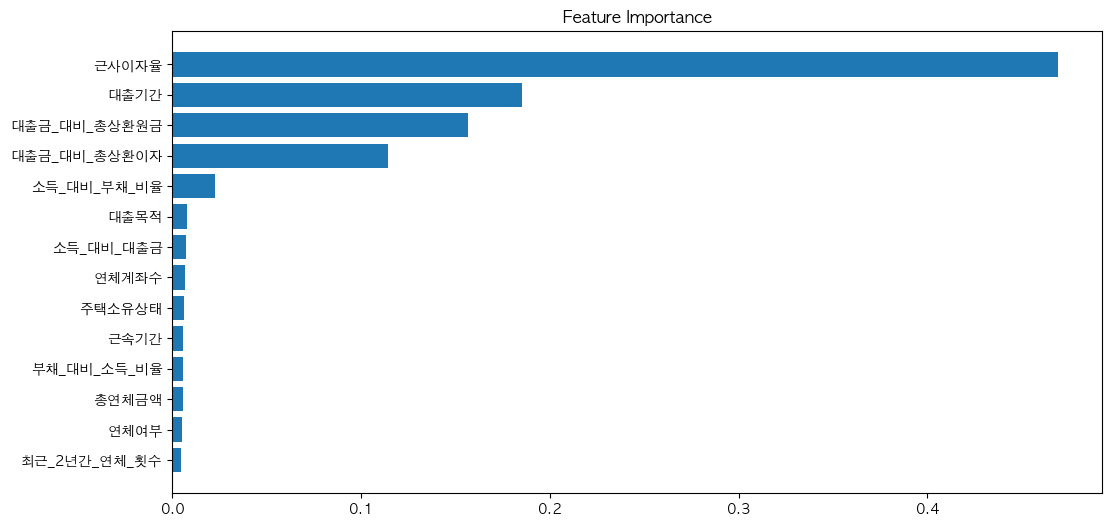

3-Fold F1-Score : 0.9490596810711056
              precision    recall  f1-score   support

           0      0.963     0.960     0.962      3353
           1      0.951     0.960     0.955      5763
           2      0.946     0.962     0.954      5523
           3      0.964     0.943     0.954      2669
           4      0.971     0.933     0.952      1469
           5      0.968     0.918     0.942       390
           6      0.961     0.892     0.925        83

    accuracy                          0.955     19250
   macro avg      0.961     0.938     0.949     19250
weighted avg      0.955     0.955     0.955     19250

[0]	validation_0-mlogloss:1.81594
[200]	validation_0-mlogloss:0.14668
[400]	validation_0-mlogloss:0.12324
[600]	validation_0-mlogloss:0.12089
[651]	validation_0-mlogloss:0.12083


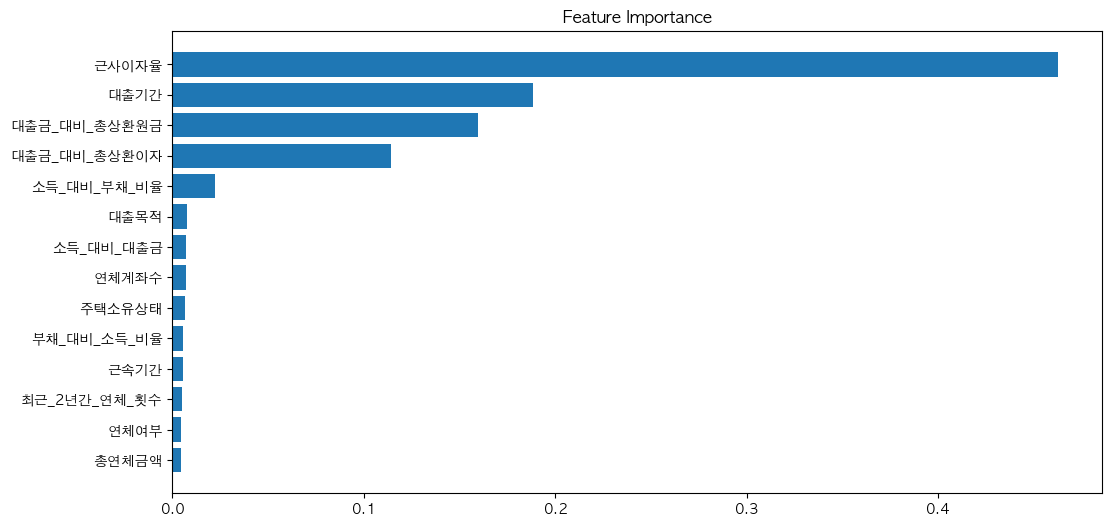

4-Fold F1-Score : 0.945535680019726
              precision    recall  f1-score   support

           0      0.966     0.956     0.961      3353
           1      0.946     0.962     0.954      5763
           2      0.943     0.961     0.952      5523
           3      0.970     0.935     0.952      2669
           4      0.961     0.935     0.948      1468
           5      0.967     0.902     0.934       389
           6      0.973     0.869     0.918        84

    accuracy                          0.953     19249
   macro avg      0.961     0.932     0.946     19249
weighted avg      0.954     0.953     0.953     19249

[0]	validation_0-mlogloss:1.81605
[200]	validation_0-mlogloss:0.14907
[400]	validation_0-mlogloss:0.12613
[600]	validation_0-mlogloss:0.12385
[602]	validation_0-mlogloss:0.12386


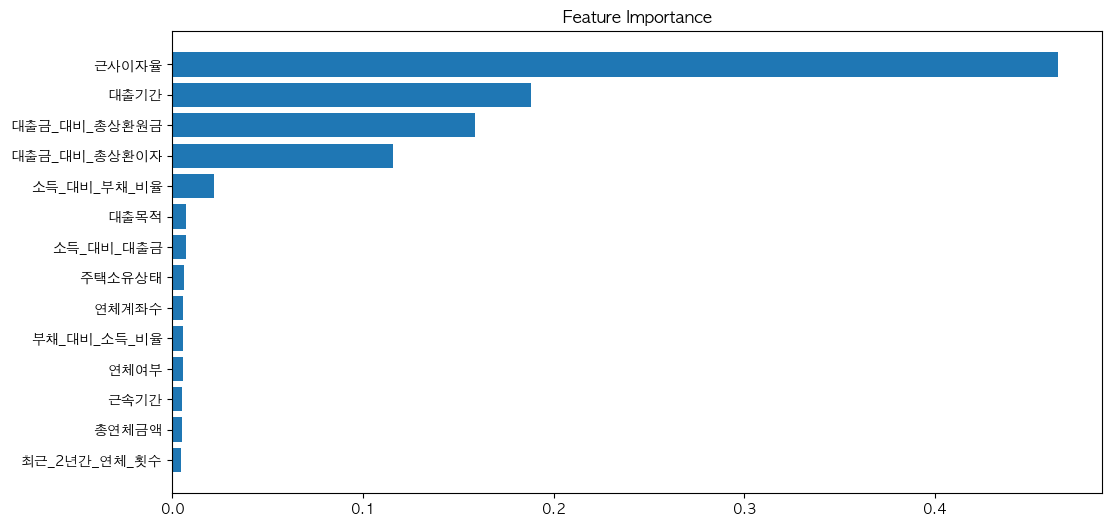

5-Fold F1-Score : 0.9394292460072781
              precision    recall  f1-score   support

           0      0.962     0.953     0.958      3353
           1      0.940     0.959     0.949      5763
           2      0.941     0.958     0.950      5524
           3      0.968     0.937     0.952      2669
           4      0.972     0.930     0.951      1469
           5      0.946     0.892     0.918       389
           6      0.947     0.855     0.899        83

    accuracy                          0.950     19250
   macro avg      0.954     0.926     0.939     19250
weighted avg      0.951     0.950     0.950     19250

[0]	validation_0-mlogloss:1.81662
[200]	validation_0-mlogloss:0.14147
[400]	validation_0-mlogloss:0.11735
[600]	validation_0-mlogloss:0.11437
[673]	validation_0-mlogloss:0.11423


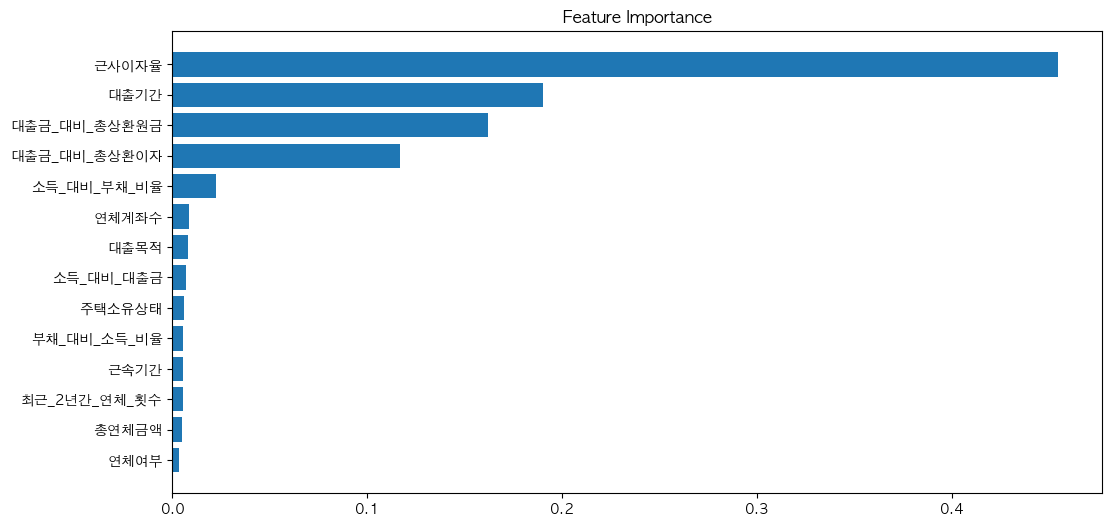

6-Fold F1-Score : 0.9436483966625138
              precision    recall  f1-score   support

           0      0.963     0.963     0.963      3354
           1      0.947     0.958     0.953      5762
           2      0.950     0.957     0.954      5524
           3      0.964     0.952     0.958      2669
           4      0.971     0.948     0.959      1469
           5      0.973     0.910     0.940       389
           6      0.932     0.831     0.879        83

    accuracy                          0.955     19250
   macro avg      0.957     0.931     0.944     19250
weighted avg      0.955     0.955     0.955     19250

[0]	validation_0-mlogloss:1.81593
[200]	validation_0-mlogloss:0.14776
[400]	validation_0-mlogloss:0.12308
[600]	validation_0-mlogloss:0.11976
[668]	validation_0-mlogloss:0.11972


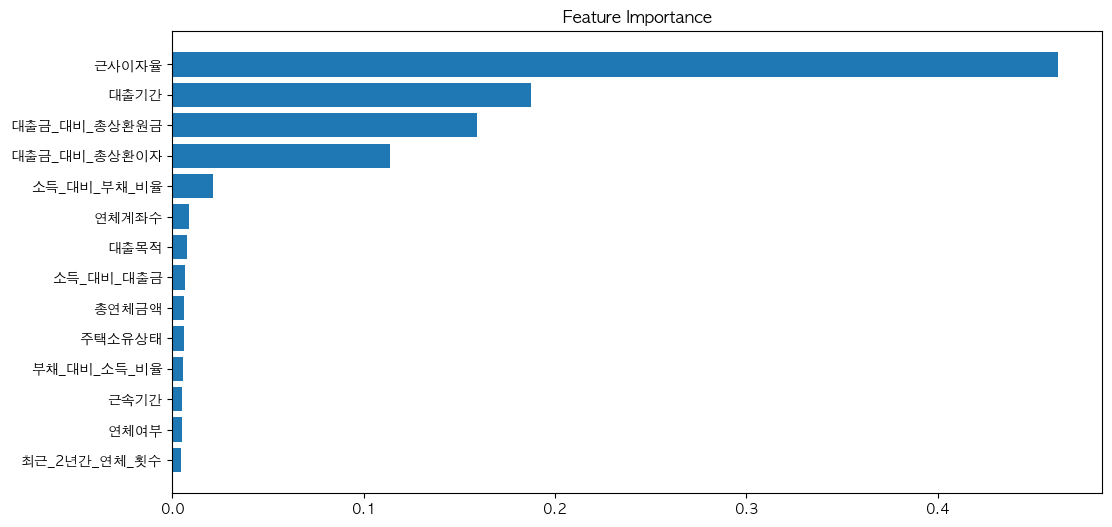

7-Fold F1-Score : 0.9452823721811853
              precision    recall  f1-score   support

           0      0.969     0.958     0.963      3354
           1      0.943     0.962     0.953      5763
           2      0.944     0.961     0.953      5523
           3      0.974     0.934     0.953      2669
           4      0.971     0.940     0.955      1469
           5      0.960     0.933     0.947       389
           6      0.934     0.855     0.893        83

    accuracy                          0.954     19250
   macro avg      0.957     0.935     0.945     19250
weighted avg      0.955     0.954     0.954     19250

[0]	validation_0-mlogloss:1.81619
[200]	validation_0-mlogloss:0.13956
[400]	validation_0-mlogloss:0.11767
[600]	validation_0-mlogloss:0.11497
[621]	validation_0-mlogloss:0.11505


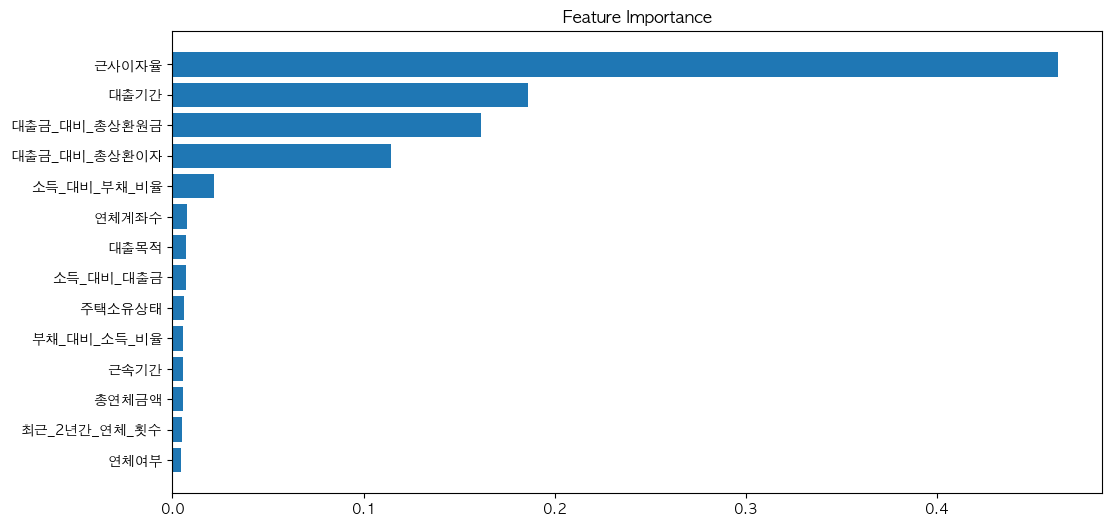

8-Fold F1-Score : 0.9438413569106032
              precision    recall  f1-score   support

           0      0.969     0.958     0.963      3353
           1      0.951     0.963     0.957      5763
           2      0.944     0.961     0.952      5523
           3      0.969     0.940     0.954      2669
           4      0.962     0.939     0.950      1469
           5      0.963     0.923     0.942       390
           6      0.922     0.855     0.887        83

    accuracy                          0.955     19250
   macro avg      0.954     0.934     0.944     19250
weighted avg      0.955     0.955     0.955     19250

[0]	validation_0-mlogloss:1.81545
[200]	validation_0-mlogloss:0.14337
[400]	validation_0-mlogloss:0.12056
[582]	validation_0-mlogloss:0.11834


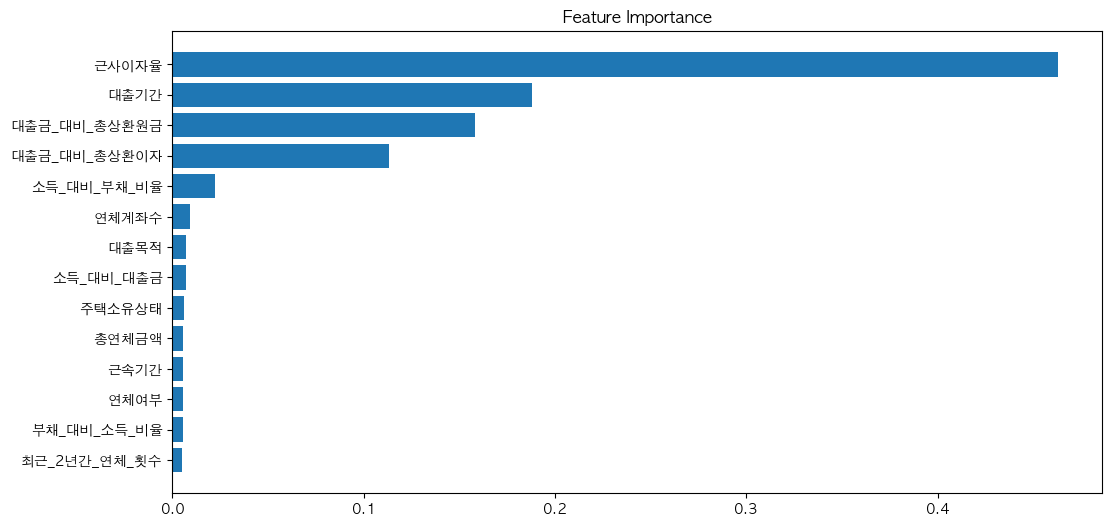

9-Fold F1-Score : 0.9449503776686478
              precision    recall  f1-score   support

           0      0.961     0.957     0.959      3353
           1      0.947     0.959     0.953      5763
           2      0.940     0.960     0.950      5523
           3      0.977     0.939     0.958      2669
           4      0.970     0.935     0.952      1468
           5      0.959     0.907     0.933       389
           6      0.916     0.905     0.910        84

    accuracy                          0.953     19249
   macro avg      0.953     0.938     0.945     19249
weighted avg      0.953     0.953     0.953     19249

[0]	validation_0-mlogloss:1.81696
[200]	validation_0-mlogloss:0.14814
[400]	validation_0-mlogloss:0.12520
[600]	validation_0-mlogloss:0.12285
[633]	validation_0-mlogloss:0.12288


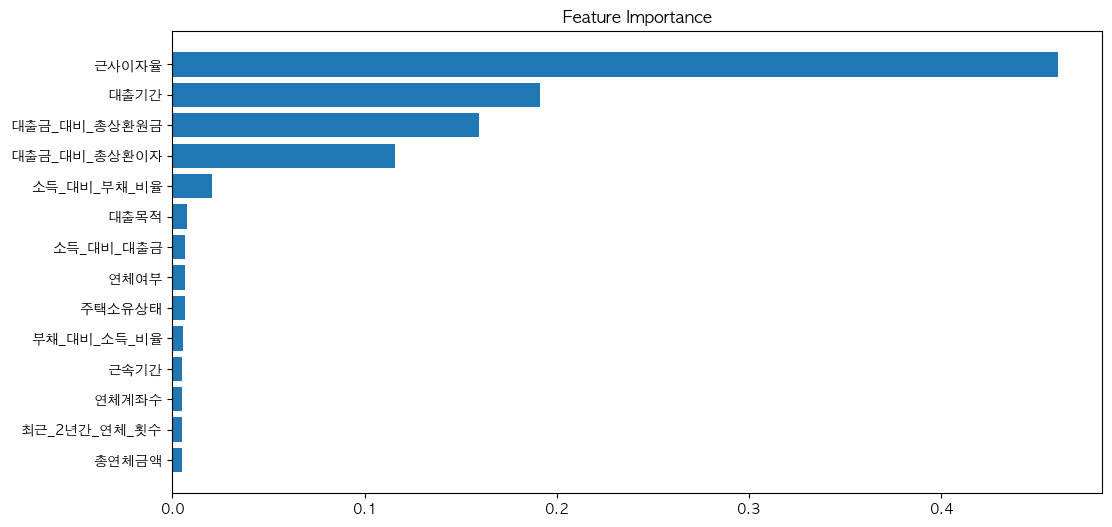

10-Fold F1-Score : 0.9375310691162719
              precision    recall  f1-score   support

           0      0.966     0.955     0.961      3353
           1      0.943     0.962     0.952      5763
           2      0.943     0.956     0.950      5524
           3      0.965     0.936     0.950      2669
           4      0.968     0.938     0.953      1469
           5      0.946     0.905     0.925       389
           6      0.932     0.819     0.872        83

    accuracy                          0.952     19250
   macro avg      0.952     0.924     0.938     19250
weighted avg      0.952     0.952     0.952     19250

[0]	validation_0-mlogloss:1.81595
[200]	validation_0-mlogloss:0.14474
[400]	validation_0-mlogloss:0.12056
[600]	validation_0-mlogloss:0.11808
[646]	validation_0-mlogloss:0.11803


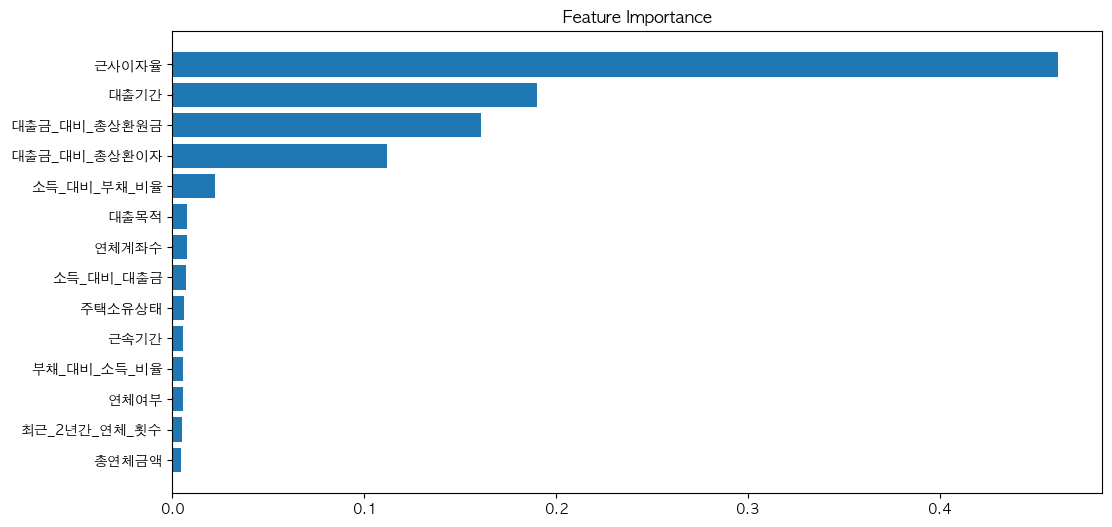

11-Fold F1-Score : 0.9473580080504487
              precision    recall  f1-score   support

           0      0.964     0.958     0.961      3354
           1      0.945     0.961     0.953      5762
           2      0.944     0.959     0.951      5524
           3      0.966     0.938     0.952      2669
           4      0.977     0.938     0.957      1469
           5      0.959     0.907     0.933       389
           6      0.973     0.880     0.924        83

    accuracy                          0.954     19250
   macro avg      0.961     0.934     0.947     19250
weighted avg      0.954     0.954     0.954     19250

[0]	validation_0-mlogloss:1.81560
[200]	validation_0-mlogloss:0.14137
[400]	validation_0-mlogloss:0.11865
[600]	validation_0-mlogloss:0.11599
[730]	validation_0-mlogloss:0.11548


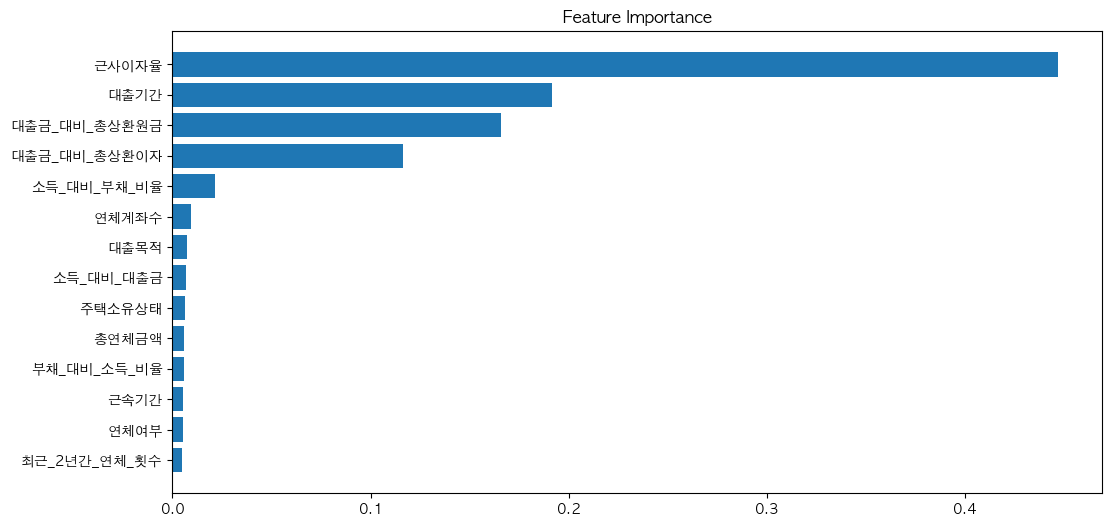

12-Fold F1-Score : 0.9391694496804724
              precision    recall  f1-score   support

           0      0.961     0.955     0.958      3354
           1      0.945     0.962     0.954      5763
           2      0.948     0.960     0.954      5523
           3      0.972     0.941     0.956      2669
           4      0.966     0.939     0.953      1469
           5      0.954     0.900     0.926       389
           6      0.920     0.831     0.873        83

    accuracy                          0.954     19250
   macro avg      0.952     0.927     0.939     19250
weighted avg      0.954     0.954     0.954     19250

[0]	validation_0-mlogloss:1.81657
[200]	validation_0-mlogloss:0.14467
[400]	validation_0-mlogloss:0.12220
[600]	validation_0-mlogloss:0.11988
[671]	validation_0-mlogloss:0.11967


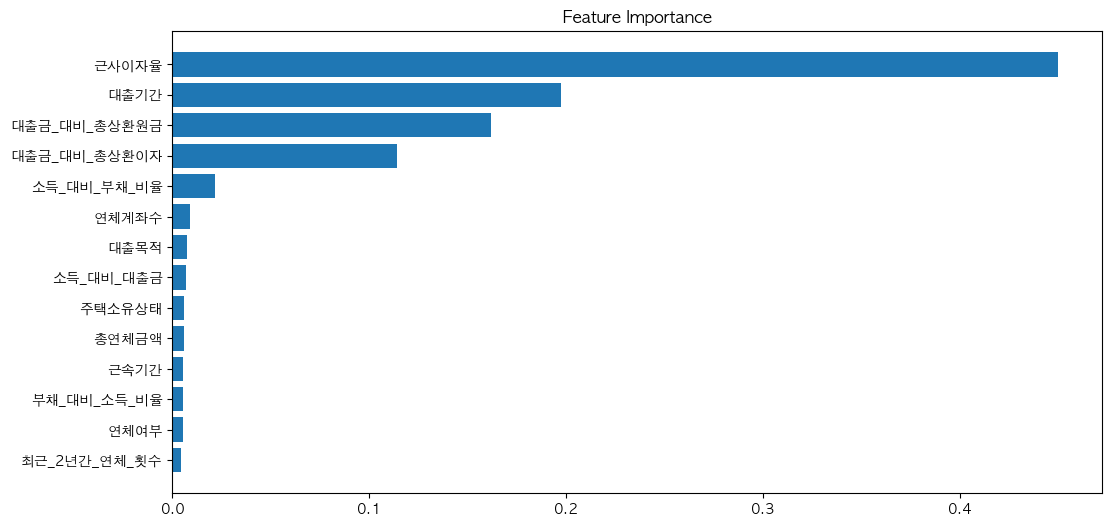

13-Fold F1-Score : 0.9414273521061267
              precision    recall  f1-score   support

           0      0.970     0.957     0.964      3353
           1      0.941     0.961     0.951      5763
           2      0.943     0.959     0.951      5523
           3      0.976     0.938     0.956      2669
           4      0.971     0.942     0.956      1469
           5      0.955     0.921     0.937       390
           6      0.909     0.843     0.875        83

    accuracy                          0.954     19250
   macro avg      0.952     0.931     0.941     19250
weighted avg      0.954     0.954     0.954     19250

[0]	validation_0-mlogloss:1.81640
[200]	validation_0-mlogloss:0.14246
[400]	validation_0-mlogloss:0.11834
[600]	validation_0-mlogloss:0.11579
[720]	validation_0-mlogloss:0.11550


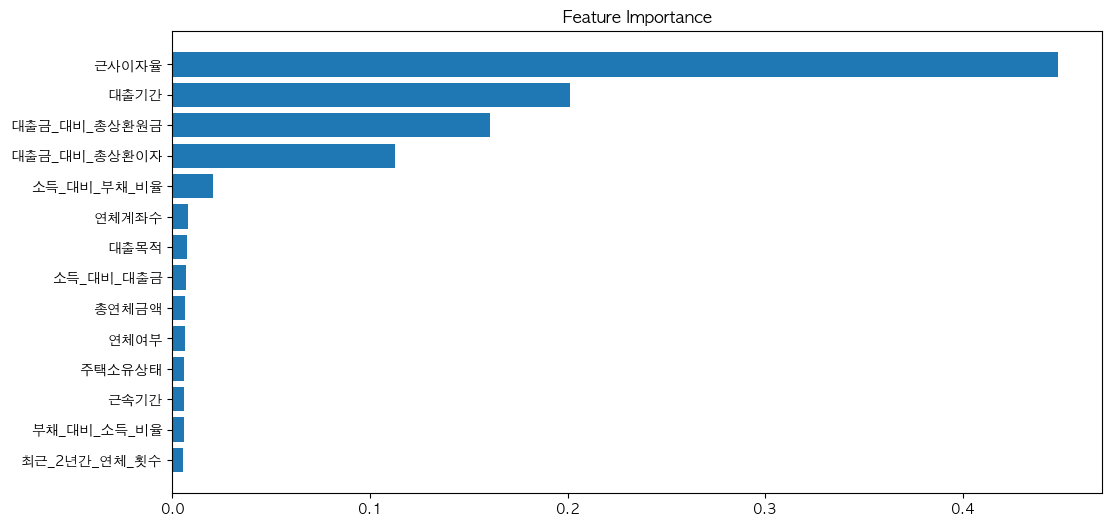

14-Fold F1-Score : 0.9553626946215724
              precision    recall  f1-score   support

           0      0.966     0.960     0.963      3353
           1      0.950     0.959     0.954      5763
           2      0.942     0.965     0.953      5523
           3      0.971     0.943     0.957      2669
           4      0.977     0.933     0.954      1468
           5      0.978     0.920     0.948       389
           6      0.987     0.929     0.957        84

    accuracy                          0.956     19249
   macro avg      0.967     0.944     0.955     19249
weighted avg      0.956     0.956     0.956     19249



In [74]:
pred = []
dict_f1 = {}
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

k = 0
for train_index, valid_index in rskf.split(train_X, train_y):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    # train_sample_weight = CreateBalancedSampleWeights(y_train['대출등급'], largest_class_weight_coef=1)

    model = XGBClassifier(max_depth=5,
                          n_estimators=5000,
                          learning_rate=0.05,
                          missing=np.nan,
                          tree_method="approx",
                          objective='multi:softmax',
                          eval_metric='mlogloss',
                          enable_categorical=True,
                          early_stopping_rounds=20,
                          colsample_bytree=0.8,
                          colsample_bylevel=0.8,
                          subsample=1.0,
                          gamma=0,
                          seed=42,
                          )
    

    model.fit(X_train, y_train,
              eval_set=[(X_valid, y_valid)],
              #sample_weight=train_sample_weight,
              verbose=200)
    
    
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

    pred_val = model.predict(X_valid)


    F1 = f1_score(y_valid, pred_val, average='macro')
    dict_f1[str(k)]=F1
    print(f'{k}-Fold F1-Score : {F1}')
    print(classification_report(y_valid, pred_val, digits=3))

    prob = model.predict_proba(X_test)
    pred.append(prob)

    k+=1
    

In [75]:
df_f1 = pd.DataFrame(dict_f1.values())
df_f1.columns = ['f1_score']
display(df_f1)
print(np.mean(df_f1['f1_score']))
#0.9445300489580999

,f1_score
0,0.941701
1,0.943304
2,0.942048
3,0.949060
4,0.945536
5,0.939429
6,0.943648
7,0.945282
8,0.943841
9,0.944950


0.9439765373263901


In [76]:
pred_prob = pred
final = np.zeros(shape=(len(X_test), 7))

for prob in pred_prob:

    final+=prob

final = encoder.inverse_transform(np.argmax(final, axis=1))

In [79]:
final = encoder.inverse_transform(np.argmax(pred_prob[-1], axis=1))

# Submission

In [80]:
sub = pd.read_csv('open/sample_submission.csv')
sub['대출등급'] = final
sub.head()
print(sub['대출등급'].value_counts())

대출등급
B    19407
C    18752
A    11162
D     8618
E     4698
F     1287
G      273
Name: count, dtype: int64


In [81]:
sub.to_csv('final_sub.csv', index=False)